<a href="https://colab.research.google.com/github/PaulToronto/Hands-on-Maching-Learning-Book/blob/main/2_End_to_End_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Machine Learning Project

- [Steps of a Machine Learning Project](https://github.com/PaulToronto/Math-and-Data-Science-Reference/blob/main/Steps_of_a_Machine_Learning_Project.ipynb)
    - [Appendix A: Machine Learning Project Checklist](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/app01.html)
- [List of Data Sources](https://github.com/PaulToronto/Math-and-Data-Science-Reference/blob/main/List_of_Data_Sources.ipynb)

## Some Terminology

- ***Multiple regression***: multiple features
- ***Multivariate regression***: predict multiple values
- ***Univariate regression***: predict a single value

## Imports

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Gaussian radial basis function
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

# the easy way to create custom transformers
from sklearn.preprocessing import FunctionTransformer

# for custom transformers that can be trained
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from scipy import stats

### Mount Google Drive

In [2]:
drive.mount('/content/gdrive')

data_path = '/content/gdrive/MyDrive/Colab Notebooks/Data Science/Hands-On Machine Learning - Book/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Performance Measures

### RMSE

- A typical performance measure for for regression problems is *root mean square error* (RMSE).
    - A higher weight is given to large errors
    - corresponds to the **Euclidian norm** or **l2 norm**

$$
RMSE\left(\textbf{X}, h\right) = \sqrt{
    \frac{1}{m} \sum{_{i=1}^{m}}\left(h\left(\textbf{x}^{(i)}\right) - y^{(i)}\right)^{2}
}
$$

- $m$ is the number of instances in the dataset
- $\mathbf{x}^{(i)}$ is a vector of all the feature values (excluding the label) of the $i^{th}$ instance
- $y^{(i)}$ is the label of the $i^{th}$ instance
- $\mathbf{X}$ is a matrix containing all the feature values (excluding the labels) of all instances in the dataset. There is one row per instance and the $i^{th}$ row is equal to the transpose of $\mathbf{x}^{(i)}$ or $\left(\mathbf{x}^{(i)}\right)^{T}$
- $h$ is your system's prediction function, aka hypothesis

### MAE

- A less common performance measure is *mean absolute error* (MAE).
    - Might be a better choice when there are outliers
    - corresponds to the **Manhattan norm** or **l1 norm**

$$
MAE\left(\textbf{X}, h\right) =
    \frac{1}{m} \sum_{i=1}^{m}\lvert h\left(\textbf{x}^{(i)}\right) - y^{(i)}\rvert
$$

## The Data

In [3]:
data_url = 'https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv'
housing = pd.read_csv(data_url)

In [4]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Preliminary EDA

- `total_bedrooms` has missing data
- all attributes are numerical except `ocean_proximity`

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

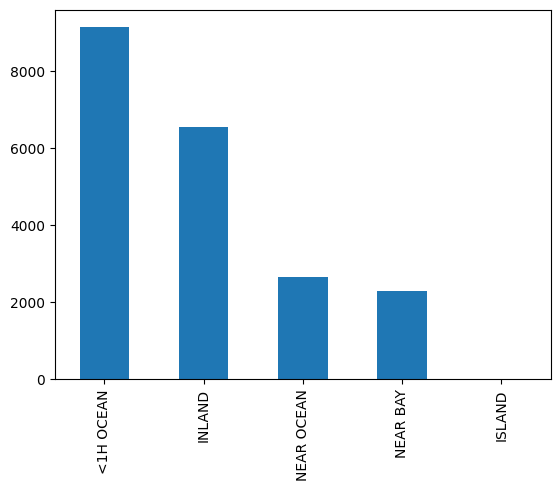

In [7]:
housing['ocean_proximity'].value_counts().plot(kind='bar');

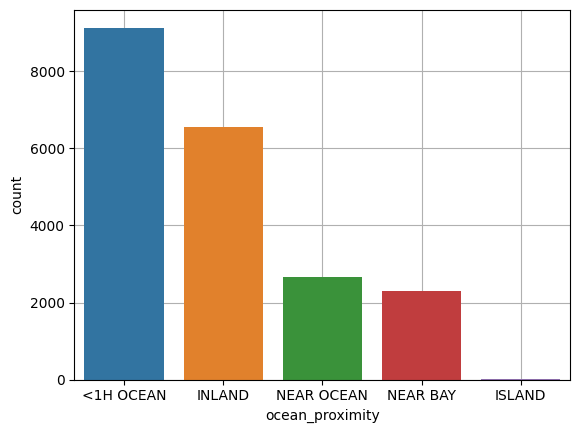

In [8]:
ax = sns.countplot(data=housing,
                   x='ocean_proximity',
                   order=housing['ocean_proximity'].value_counts().index)
ax.grid()
ax.set_axisbelow(True) # controls z-order

In [9]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

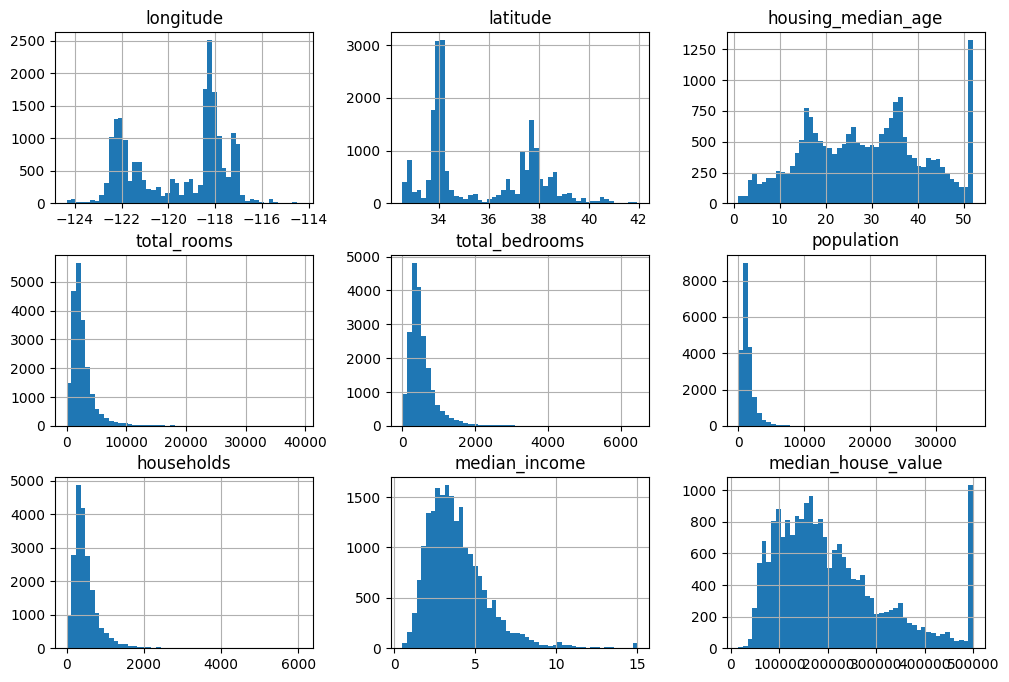

In [10]:
housing.hist(bins=50, figsize=(12, 8));

- `median_income` does not look like it's expressed in US dollars
- the data has been scaled between 0.4999 and 15.0001
- 3 means about 30K dollars

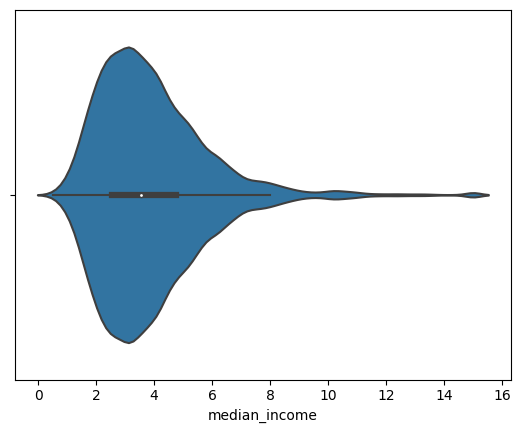

In [11]:
sns.violinplot(data=housing, x='median_income');

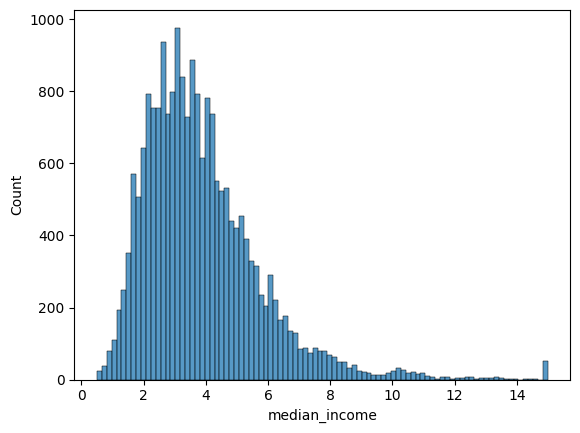

In [12]:
sns.histplot(data=housing, x='median_income');

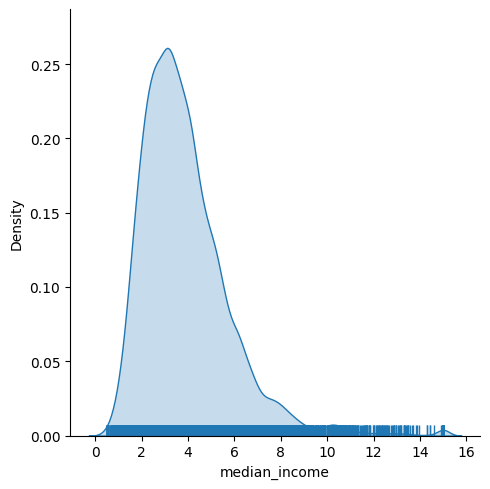

In [13]:
sns.displot(data=housing, x='median_income', kind='kde', rug=True, fill=True);

- `housing_median_age` was capped
- `housing_median_value` was capped
    - this one could be a serious problem since it is the target attribute
    - two options:
        1. collect proper labels for the districts whose labels were capped
        2. remove those districts from the training and test set
- the attributes have very different scales
- many of the histograms are skewed right

## Create a Test Set

- the test set should be left alone once created
- no further EDA should be done on the test set to avoid **data snooping bias**

In [14]:
train_set, test_set = train_test_split(housing, test_size=0.2)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

## A Stratified Test Set

- Maybe it is better to stratify the train, test split by `median_income`
- To do this we need to create `income_cat` feature

In [15]:
housing['median_income'].min(), housing['median_income'].max()

(0.4999, 15.0001)

In [16]:
# note, closed interval includes endpoints,
# use square brackets for closed, parenthesis for open
# right=True by default
#   - indicates whether bins includes the rightmost edge or not.
#     when right=True, then the bins [1, 2, 3, 4]
#     indicate (1,2], (2,3], (3,4].

test = np.concatenate([np.arange(0, 1.5, 0.5),
                       np.arange(1.5, 3.0, 0.5),
                       np.arange(3.0, 4.5, 0.5),
                       np.arange(4.5, 6.0, 0.5),
                       np.arange(6.0, 10, 0.5)
                      ])
test

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

In [17]:
test_result = pd.cut(test,
                     bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                     labels=[1, 2, 3, 4, 5])

In [18]:
pd.DataFrame({'test': test, 'result': test_result})

test result
0    0.0    NaN
1    0.5      1
2    1.0      1
3    1.5      1
4    2.0      2
5    2.5      2
6    3.0      2
7    3.5      3
8    4.0      3
9    4.5      3
10   5.0      4
11   5.5      4
12   6.0      4
13   6.5      5
14   7.0      5
15   7.5      5
16   8.0      5
17   8.5      5
18   9.0      5
19   9.5      5

In [19]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
housing.groupby('income_cat')['median_income'].aggregate(['count', 'min', 'max'])

count     min      max
income_cat                        
1             822  0.4999   1.5000
2            6581  1.5026   3.0000
3            7236  3.0021   4.5000
4            3639  4.5022   6.0000
5            2362  6.0050  15.0001

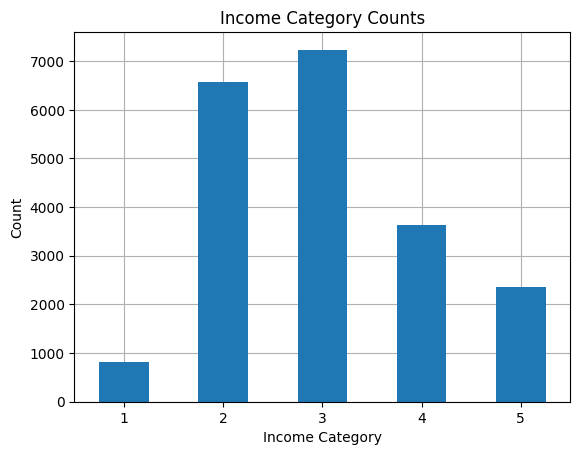

In [22]:
ax = housing['income_cat'].value_counts().sort_index().plot(kind='bar',
                                                            grid=True,
                                                            rot=0,
                                                            xlabel='Income Category',
                                                            ylabel='Count',
                                                            title='Income Category Counts');
ax.set_axisbelow(True);

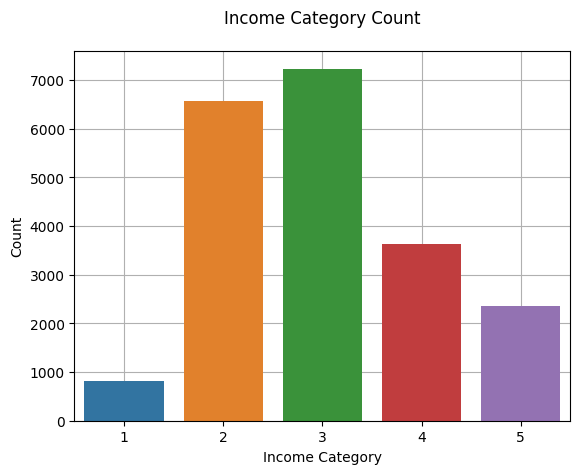

In [23]:
ax = sns.countplot(data=housing,
                   x='income_cat')

ax.set(xlabel='Income Category',
       ylabel='Count',
       #title='Income Category Count',
       axisbelow=True)

ax.set_title('Income Category Count', pad=20)
ax.grid();

## `train_test_split()` with stratify argument

You may want to stratify based on a particular feature, especially if domain knowledge dictates that this is a particularly important feature for predicting the target.

In [24]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [25]:
train_set.shape, test_set.shape, strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11), (16512, 11), (4128, 11))

In [26]:
overall = housing['income_cat'].value_counts(normalize=True).sort_index() * 100
random_train = train_set['income_cat'].value_counts(normalize=True).sort_index() * 100
random_test = test_set['income_cat'].value_counts(normalize=True).sort_index() * 100
strat_train = strat_train_set['income_cat'].value_counts(normalize=True).sort_index() * 100
strat_test = strat_test_set['income_cat'].value_counts(normalize=True).sort_index() * 100


df = pd.DataFrame({'Overall %': overall,
                   'Train % Random': random_train,
                   'Test % Random': random_test,
                   'Train % Stratified': strat_train,
                   'Test % Stratified': strat_test
                   })
df

Overall %  Train % Random  Test % Random  Train % Stratified  \
1   3.982558        3.918362       4.239341            3.978924   
2  31.884690       32.170543      30.741279           31.885901   
3  35.058140       35.192587      34.520349           35.059351   
4  17.630814       17.435804      18.410853           17.629603   
5  11.443798       11.282703      12.088178           11.446221   

   Test % Stratified  
1           3.997093  
2          31.879845  
3          35.053295  
4          17.635659  
5          11.434109

- We no longer need the `income_cat` column, so we might as well drop it
- We are putting the test set aside to avoid data snooping bias

In [27]:
for set_ in (strat_train_set, strat_test_set):
   set_.drop('income_cat', axis=1, inplace=True)

In [28]:
housing = strat_train_set.copy()

## Explore and Visualize the Data to Gain Insights

- If the data set is too large, consider taking a random sample to use for this stage to make data manipulations easy and fast

### Visualizing Geographical Data

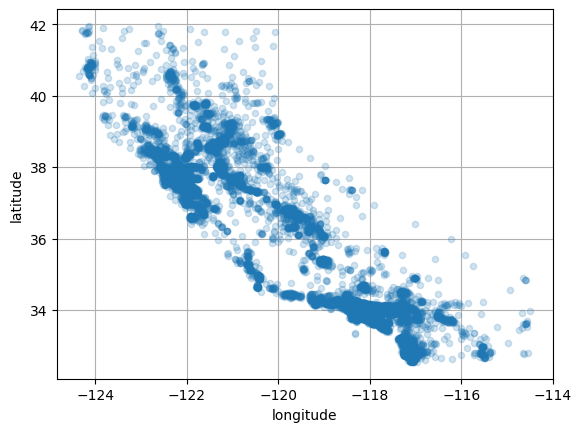

In [29]:
ax = housing.plot(kind='scatter',
                  x='longitude',
                  y='latitude',
                  alpha=0.2,
                  grid=True)
ax.set_axisbelow(True)
#ax.set(axisbelow=True);
#ax.grid();

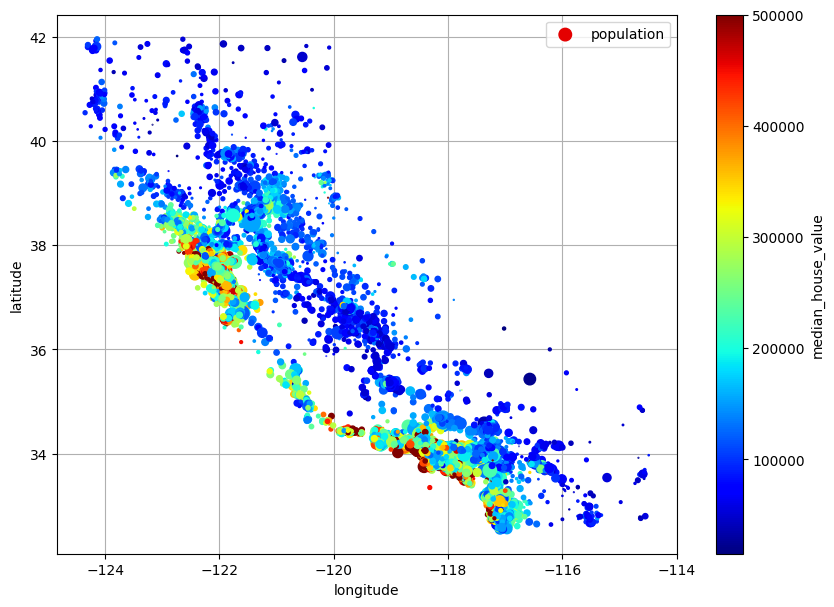

In [30]:
ax = housing.plot(kind='scatter',
                  x='longitude',
                  y='latitude',
                  s=housing['population'] / 100,
                  c='median_house_value',
                  colorbar=True,
                  cmap='jet',
                  label='population',
                  legend=True,
                  grid=True,
                  figsize=(10, 7))
ax.set_axisbelow(True)

#### What does the image tell us?

- Housing prices are very much related to location
    - Close to ocean means higher price
    - Close to population centers means higher price
- A **clustering algorithm** should be useful for detecting the main cluster and for adding new features that measure proximity to the cluster centers
- The `ocean_proxmimity` fature may be useful as well, but it doesn't apply to Northern California

### Look for Correlations

In [31]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm',
                                      vmin=-1,
                                      vmax=1)

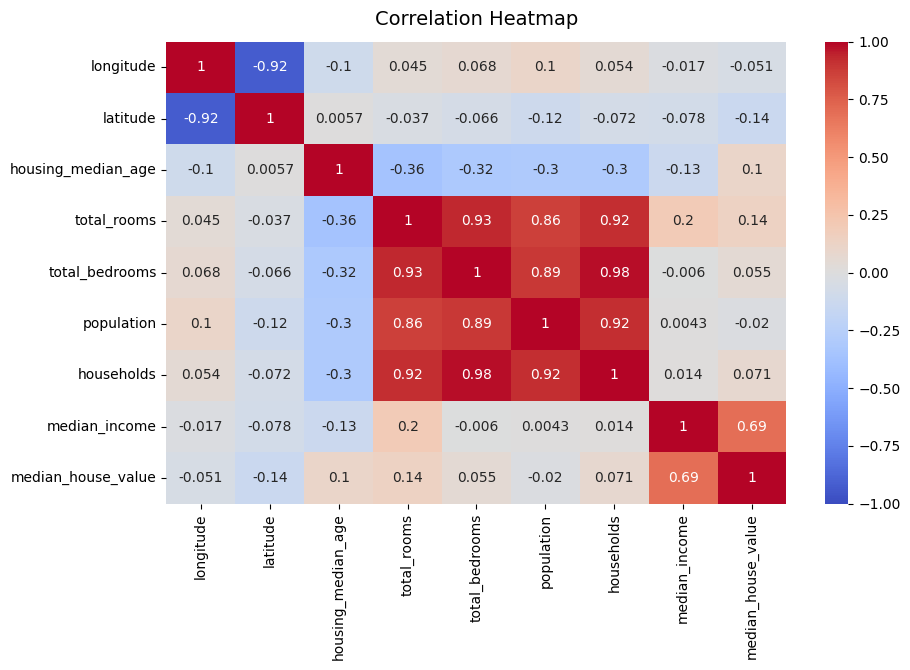

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix,
            cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, annot_kws={'fontsize': 10})
ax.set_title('Correlation Heatmap', fontdict={'fontsize': 14}, pad=12);

In [33]:
mask = np.triu(np.ones_like(corr_matrix, dtype='bool'))
np.fill_diagonal(mask, False)
mask

array([[False,  True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False, False, False]])

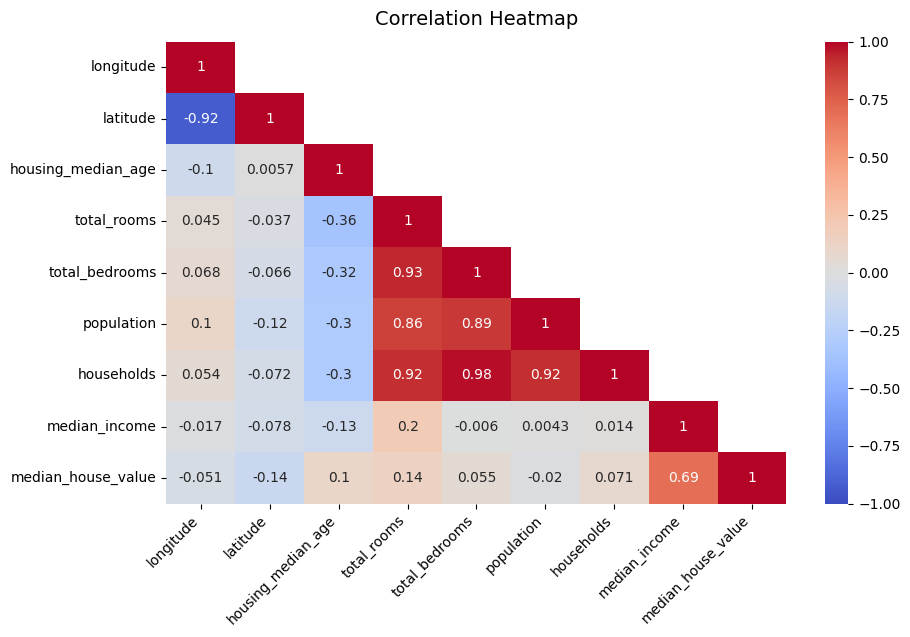

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask,
            cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, annot_kws={'fontsize': 10})
ax.set_title('Correlation Heatmap', fontdict={'fontsize': 14}, pad=12)
ax.set_xticklabels(ax.get_xticklabels(), size=10, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), size=10);

In [35]:
corr_target = corr_matrix[['median_house_value']].sort_values(by='median_house_value', ascending=False)
corr_target.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

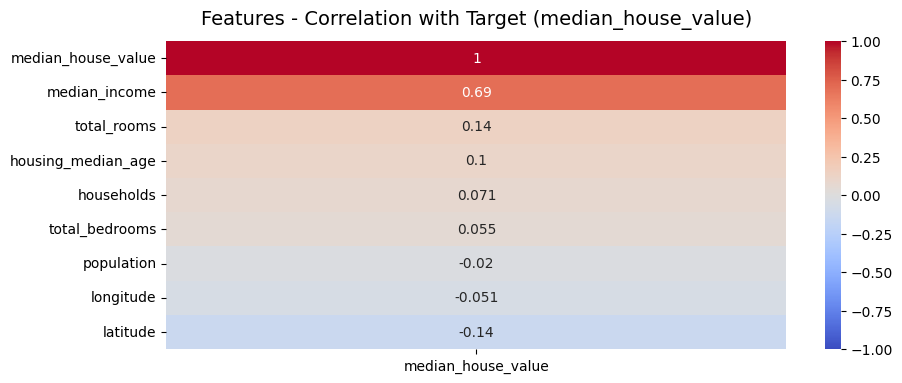

In [36]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(corr_target,
            cmap='coolwarm', vmin=-1, vmax=1,
            annot=True, annot_kws={'fontsize': 10});
ax.set_title('Features - Correlation with Target (median_house_value)', fontdict={'fontsize': 14}, pad=12);


#### The correlation coefficients only measure linear correlations

- Scatter plots can help reveal nonlinear relationships

In [37]:
corr_target.index

Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age', 'households', 'total_bedrooms', 'population',
       'longitude', 'latitude'],
      dtype='object')

In [38]:
attributes1 = corr_target.index[:5]
attributes2 = corr_target.index[5:].insert(0, corr_target.index[0])

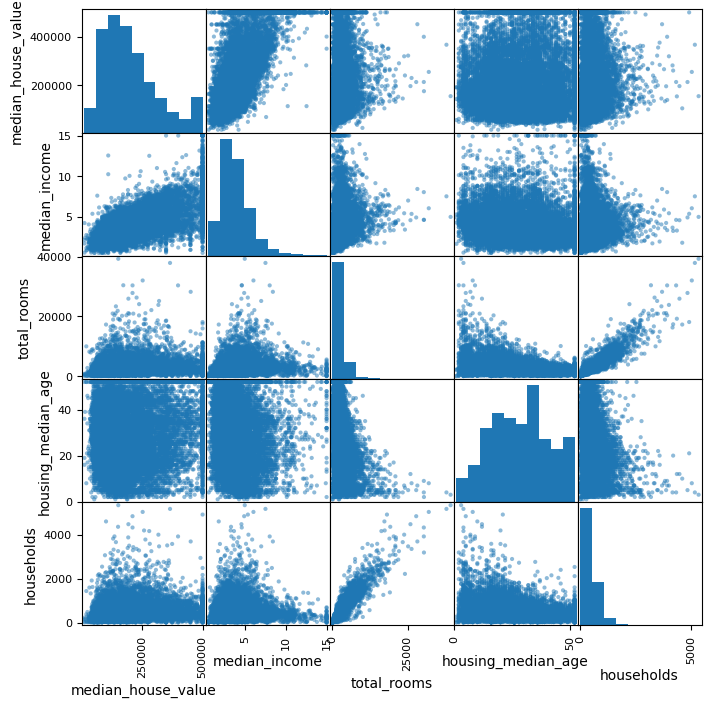

In [39]:
pd.plotting.scatter_matrix(housing[attributes1], figsize=(8, 8));

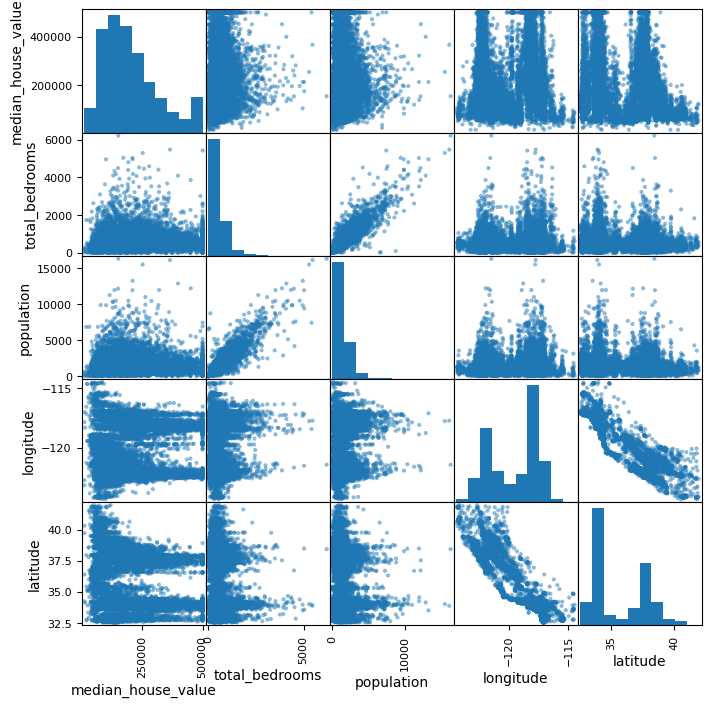

In [40]:
pd.plotting.scatter_matrix(housing[attributes2], figsize=(8, 8));

- Improved appearnce using seaborn

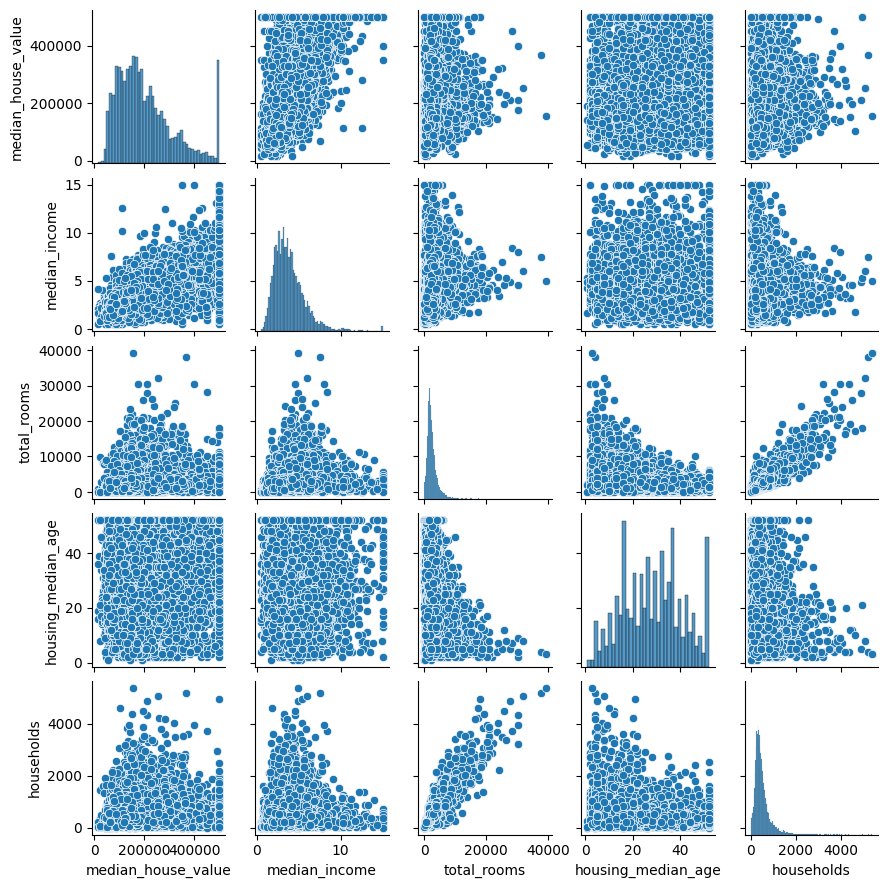

In [41]:
sns.pairplot(housing[attributes1], height=1.8);

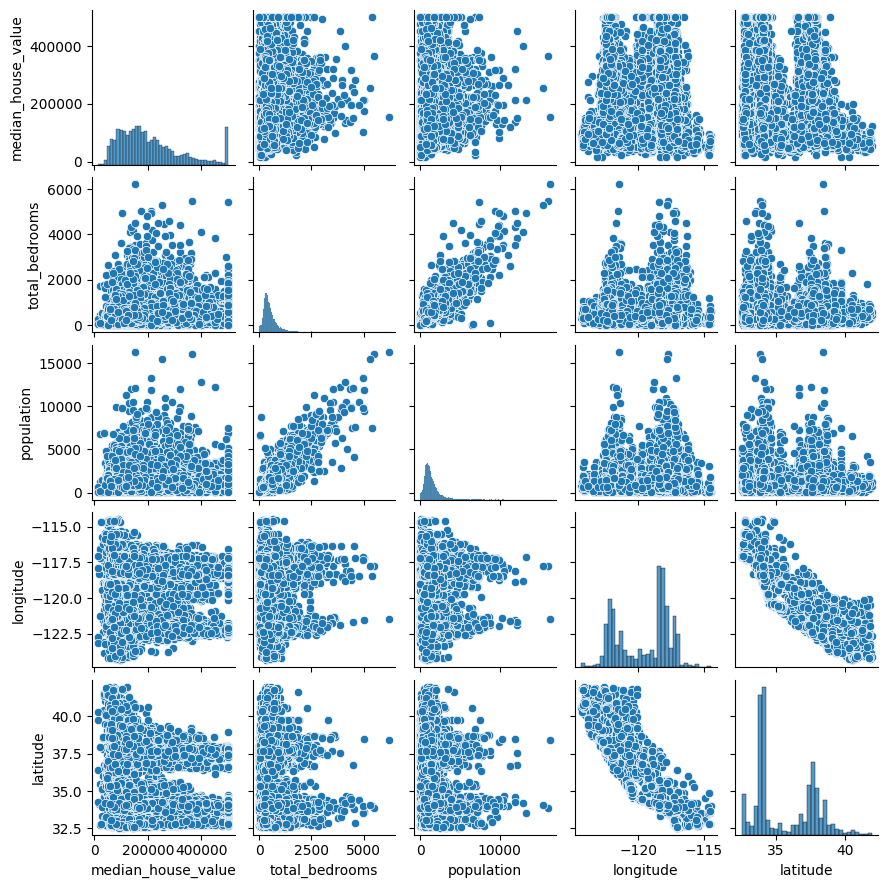

In [42]:
sns.pairplot(housing[attributes2], height=1.8);

#### `median_income`

- It looks like `median_income` is the most promising attribute for predicting `median_house_value`
- The correlation is quite strong
- The price cap discussed earlier is clearly visible as the horiontal line at 500K
- The plot also reveals some other, less obvious horizontal lines
    - It might be a good idea to remove the corresponding districts to prevent your algorithm from learning to reproduce these quirks

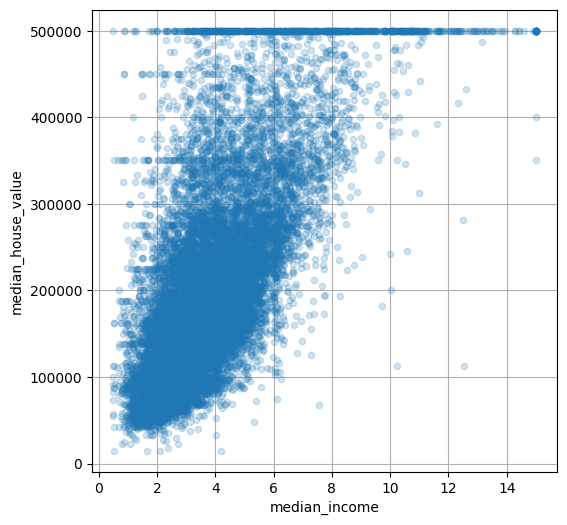

In [43]:
ax = housing.plot(kind='scatter',
             x='median_income',
             y='median_house_value',
             alpha=0.2,
             grid=True,
             figsize=(6, 6))

ax.set_axisbelow(True);

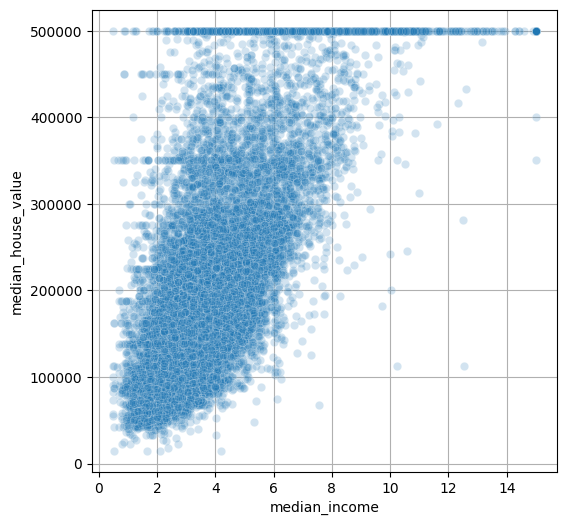

In [44]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(data=housing, x='median_income', y='median_house_value', alpha=0.2)
ax.set_axisbelow(True)
ax.grid();

### Experiment with Attribute Combinations

- The total number of rooms in the district is not very useful if you don't know how many households there are.
- The number of bedrooms might be more useful it it is compared to the number of rooms
- Population per household might also be useful

In [45]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [46]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [47]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  rooms_per_house     16512 non-null  float64
 11  bedrooms_ratio      16344 non-null  float64
 12  people_per_house    16512 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


In [48]:
corr_matrix = housing.corr(numeric_only=True)
corr_target = corr_matrix[['median_house_value']].sort_values(by='median_house_value', ascending=False)
corr_target.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

## Prepare the Data for Machine Learning Algorithms

Best done using functions:

- allows you to reproduce the transformations easily on any dataset
- you will gradually build up a library of transformation functions that you can reuse in future projects
- you can use these functions in your live system to transform the new data before feeding it to your algorithms
- makes it possible to try out various transformations and see which combination of tranformations works best

### Revert to a clean training set and separate the predictors and labels

In [49]:
# note that `drop` creates a copy
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [50]:
housing.shape, housing_labels.shape

((16512, 9), (16512,))

In [51]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

In [52]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Clean the Data

- `total_bedrooms` is missing data. There are 3 options for handling this:
    1. Get rid of the corresponding districts
    2. Get rid of the entire attribute
    3. Impute the missing values
        - zero, mean, median, etc.

In [53]:
# 1. Get rid of the corresponding
housing.dropna(subset=['total_bedrooms'], inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16344 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16344 non-null  float64
 1   latitude            16344 non-null  float64
 2   housing_median_age  16344 non-null  float64
 3   total_rooms         16344 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16344 non-null  float64
 6   households          16344 non-null  float64
 7   median_income       16344 non-null  float64
 8   ocean_proximity     16344 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.2+ MB


In [54]:
# undo that
housing = strat_train_set.drop('median_house_value', axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [55]:
# 2. Get rid of the entire attribute
housing.drop('total_bedrooms', axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [56]:
# undo that
housing = strat_train_set.drop('median_house_value', axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [57]:
# 3. Impute the missing values to the median
the_median = housing['total_bedrooms'].median()
print(the_median)
housing['total_bedrooms'].fillna(the_median, inplace=True)
housing.info()

434.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [58]:
# undo that too because we will use the Scikit-learn class: `SimpleImputer`
housing = strat_train_set.drop('median_house_value', axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### `SimpleImputer()`

- the benefit of using this is that it will store the median value (of each feature), which will make it possible to impute missing values not only on the training set, but also on the test set, the validation set and any new data fed to the model
- Three steps:
    1. Create an instance of `SimpleImputer`
    2. `.fit()` it to the data
    3. .transform() the data

In [59]:
# 1. Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='median')

In [60]:
# the imputer can only be computed on numerical attriburtes
housing_num = housing.select_dtypes(include=[np.number])

In [61]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [62]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [63]:
# 2. `.fit()` the imputer instance to the data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

- The imputer has simply computed the median of each attribute and stored it in its `statistics_` instance variable
- Only the total_bedrooms attribute had missing values, but you can't be sure there won't be any missing values in the new data after the system goes love, so it is best to apply the imputer to all numerical attributes

In [64]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [65]:
housing.median(numeric_only=True)

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2125.0000
total_bedrooms         434.0000
population            1167.0000
households             408.0000
median_income            3.5385
dtype: float64

In [66]:
# 3. Use the "trained" imputer to transform the data
X  = imputer.transform(housing_num)

In [67]:
type(X)

numpy.ndarray

In [68]:
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

In [69]:
X.shape, housing_num.shape

((16512, 8), (16512, 8))

#### The next 5 cells are just an experiment to show how to tranform X back into a DataFrame

In [70]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [71]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [72]:
# housing_num = pd.DataFrame(X,
#                           columns = housing_num.columns,
#                           index = housing_num.index)

In [73]:
# housing_num.info()

In [74]:
# still has missing data
# housing.info()

Should also experiment with:

- `KNNImputer`
- `IterativeImputer`

### Scikit-Learn API

- All objects share a consistent and simple interface
    - **Estimators**: can estimate some paramaters based on a dataset.
        - example: `SimpleImputer()`
        - the estimatation itself is performed by the `fit()` method which takes a dataset as a parameter (or two in the case of supervised learning algorithms where one parameter is the dataset of labels)
        - all other paramters are called **hyperparameters**
    - **Transformers**: some estimaters (such as `SimpleImputer()`) can also tranform a dataset
        - the transformation is performed by the `transform()` method, with the dataset to transform as the parameter
        - the tranformed dataset is returned by the method
        - the tranfomration generally relies on learned parameters
        - all transformers also have the convenience method `fit_transform()`
            - sometimes optimized to run faster than `fit()` followed by `tranform()`
    - **Predictors**: some etimators, given a dataset, are capable of making predictions
        - the prediction is done with the `predict()` method, which takes a dataset of *new instances* and returns a dataset of corresponding predictions
        - also have a `score()` method that measures the quality of the predictions (given a test set, and the corresponding labels in the case of supervised learning algorithms)
- Inspection:
    - All the estimator's hyperparameters are accessible via public instances variables
        - example: `imputer.strategy`
    - All the estimator's learned parameters are accessible vail bput instance variables with an underscore suffix
        - example: `imputer.statistics_`
- Composition:
    - It is easy to create a `Pipeline` estimator from an arbitrary sequence of tranformers

### Handling Text and Categorical Attributes

In [75]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292

In [76]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN

In [77]:
housing_cat['ocean_proximity'].value_counts()

<1H OCEAN     7274
INLAND        5301
NEAR OCEAN    2089
NEAR BAY      1846
ISLAND           2
Name: ocean_proximity, dtype: int64

#### `OrdinalEncoder()`

- The problem with ordinal encoding is that ML algorithms will assum that two nearby values are more similar that two distant values
    - This may be find for ordered categories, but not for `ocean_proximity`

In [78]:
ordinal_encoder = OrdinalEncoder()

In [79]:
ordinal_encoder.fit(housing_cat)

OrdinalEncoder()

In [80]:
housing_cat_encoded = ordinal_encoder.transform(housing_cat)

In [81]:
housing_cat_encoded

array([[3.],
       [0.],
       [1.],
       ...,
       [4.],
       [0.],
       [4.]])

In [82]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### `OneHotEncoder()`

- has a `drop` parameter

In [83]:
cat_encoder = OneHotEncoder(sparse_output=True)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [84]:
# by default, the output is a sparse matrix
# can be overridden by setting sparse_output=False
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [85]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [86]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [87]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [88]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [89]:
pd.DataFrame(housing_cat_1hot.toarray(),
             columns=cat_encoder.get_feature_names_out(),
             index=housing_cat.index)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
13096                        0.0                     0.0   
14973                        1.0                     0.0   
3785                         0.0                     1.0   
14689                        0.0                     1.0   
20507                        0.0                     0.0   
...                          ...                     ...   
14207                        1.0                     0.0   
13105                        0.0                     1.0   
19301                        0.0                     0.0   
19121                        1.0                     0.0   
19888                        0.0                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   
...                       ...                       ...   
14207                     0.0                       0.0   
13105                     0.0                       0.0   
19301                     0.0                       0.0   
19121                     0.0                       0.0   
19888                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0  
...                           ...  
14207                         0.0  
13105                         0.0  
19301                         1.0  
19121                         0.0  
19888                         1.0  

[16512 rows x 5 columns]

In [90]:
housing_cat.head()

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN

In [91]:
# can also use the pd.get_dummies() function
#   trouble is, it doesn't remember which categories it was trained on
#    - best to use OneHotEncoder()
pd.get_dummies(housing_cat).head()

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
13096                          0                       0   
14973                          1                       0   
3785                           0                       1   
14689                          0                       1   
20507                          0                       0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                       0                         1   
14973                       0                         0   
3785                        0                         0   
14689                       0                         0   
20507                       0                         0   

       ocean_proximity_NEAR OCEAN  
13096                           0  
14973                           0  
3785                            0  
14689                           0  
20507                           1

### Feature Scaling and Transformation

- ML algorithms don't perform well when the input numerical attributes have very different scales
    - most models will be biased toward focusing on those attributes with a larger scale
- the two most common scaling techniques:
    1. min-max scaling (aka normalization)
    2. standardization
- What if there are outliers in "new data" to which `transform()` is applied?
    - they may end up scaled outside the range
    - to avoid this, set `clip=True`

#### `MinMaxScaler()`

The tranformation is given by:

`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))`

`X_scaled = X_std * (max - min) + min`

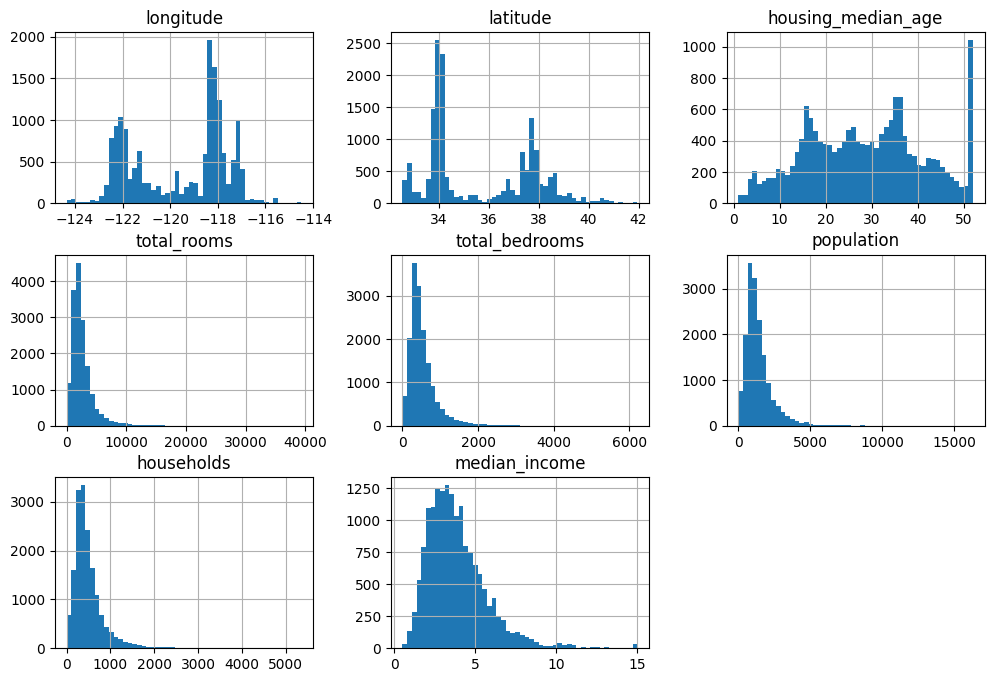

In [92]:
housing_num.hist(bins=50, figsize=(12, 8));

In [93]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

In [94]:
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [95]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

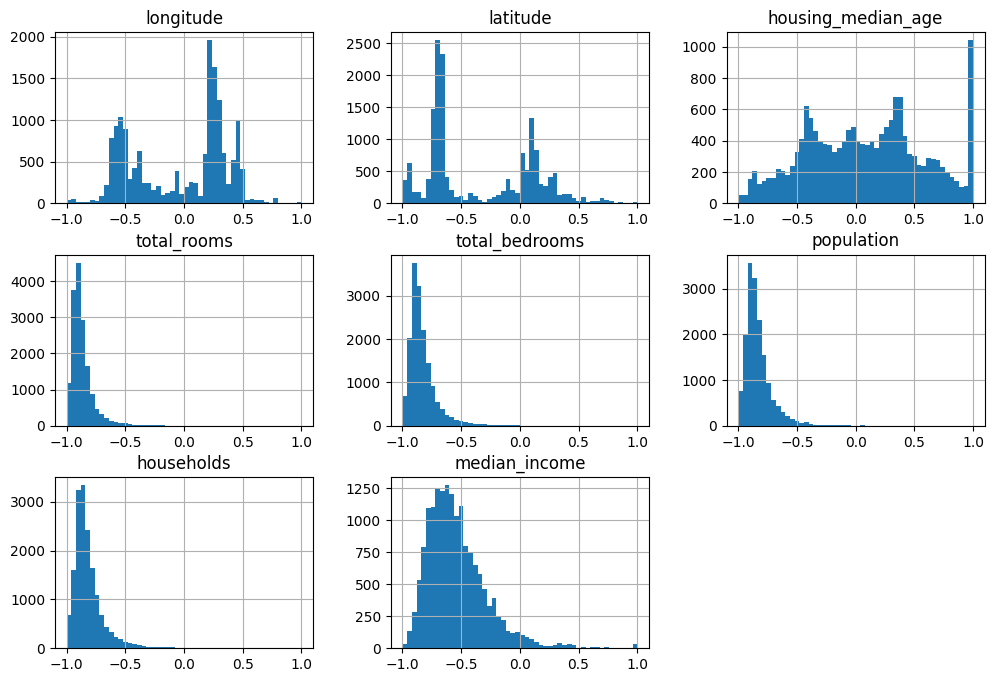

In [96]:
test_min_max = pd.DataFrame(housing_num_min_max_scaled,
             columns = housing_num.columns,
             index = housing_num.index)
test_min_max.hist(bins=50, figsize=(12, 8));

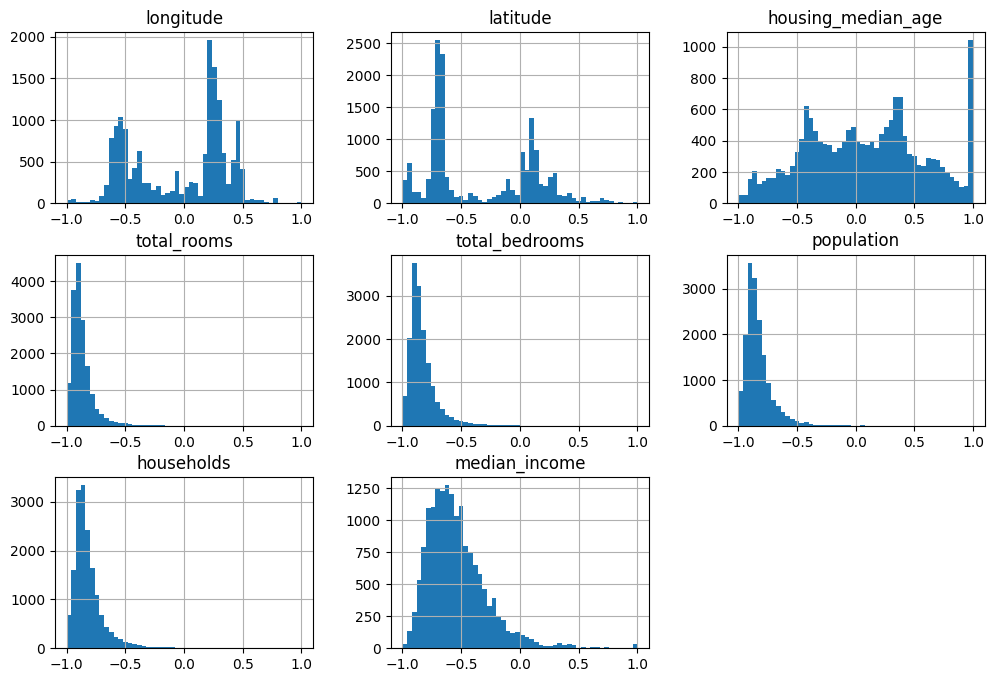

In [97]:
test = (housing_num - housing_num.min(axis=0)) / (housing_num.max(axis=0) - housing_num.min(axis=0))
test = test * (1 - (-1)) + (-1)
test.hist(bins=50, figsize=(12, 8));

#### `StandardScaler()`

`z = (x - u) / s`

- like z-scores, mean of 0 and std of 1
- less affected by outliers than min-max scaling
- If you want to scale a sparse matrix without converting it to a dense matrix first, you can use a `StandardScaler` with its `with_mean` hyperparameter set to `False`: it will only divide the data by the standard deviation, without subtracting the mean (as this would break sparsity).

In [98]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

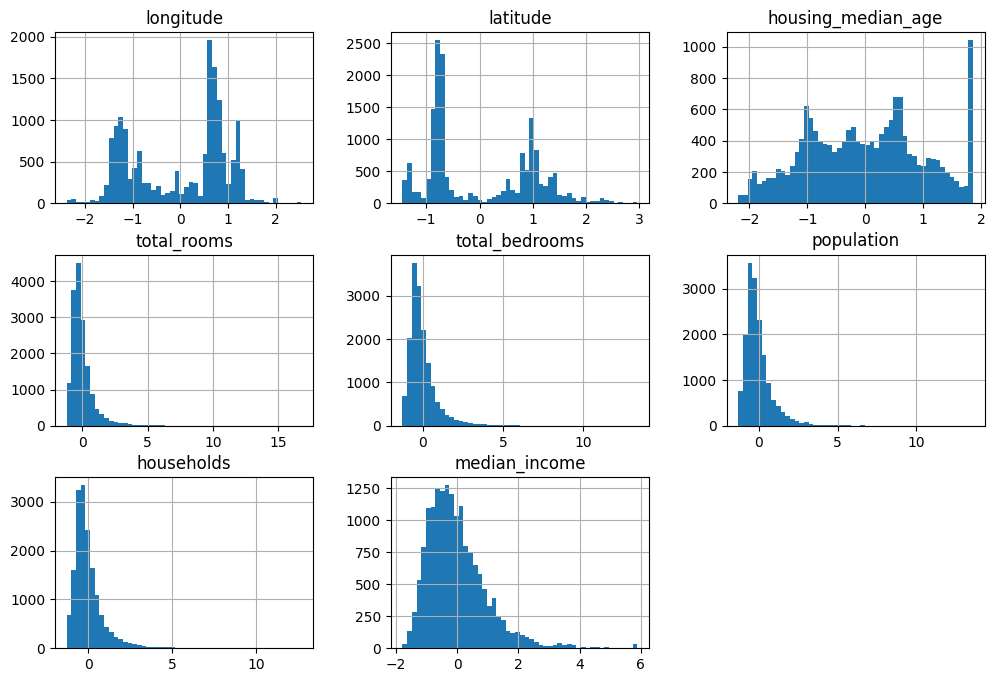

In [99]:
test_standard = pd.DataFrame(housing_num_std_scaled,
                             columns=housing_num.columns,
                             index=housing_num.index)
test_standard.hist(bins=50, figsize=(12, 8));

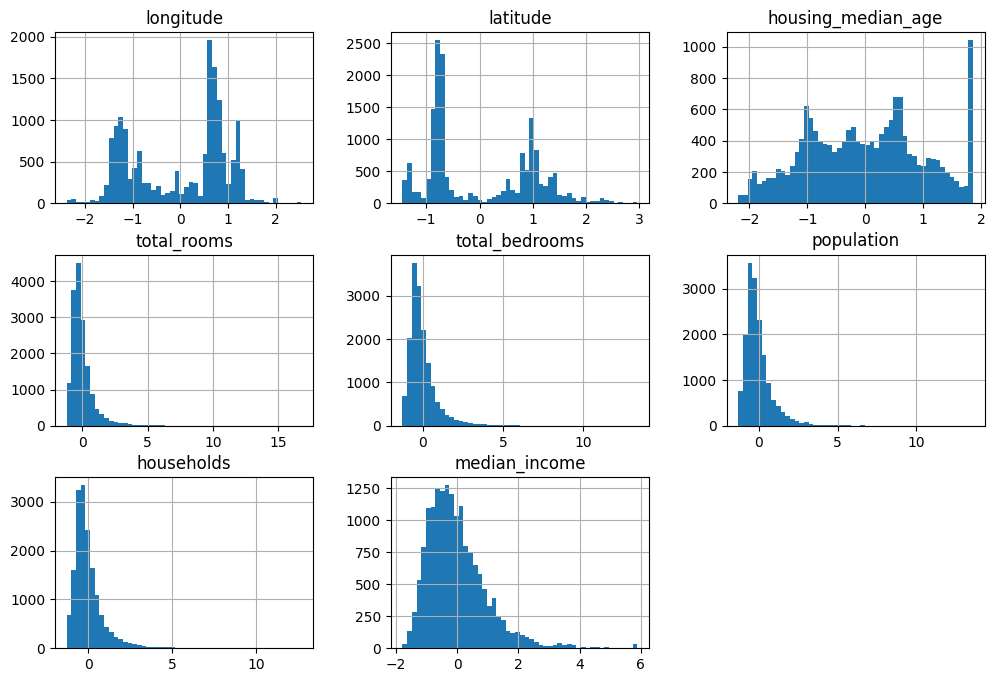

In [100]:
test = (housing_num - housing_num.mean(axis=0)) / housing_num.std(axis=0)
test.hist(bins=50, figsize=(12, 8));

#### Tranformations to reduce skew

- This should be done **before** scaling
- for **positive** features with a heavy tail to the right:
    - replace the feature with it's square root
    - or raise the feature to a power between 0 and 1
    - for a really long tail, replace the feature with it's logarithm
- You can also **bucketize** the feature
    - roughly equal sized buckets
    - for example, replace each value with it's percentile

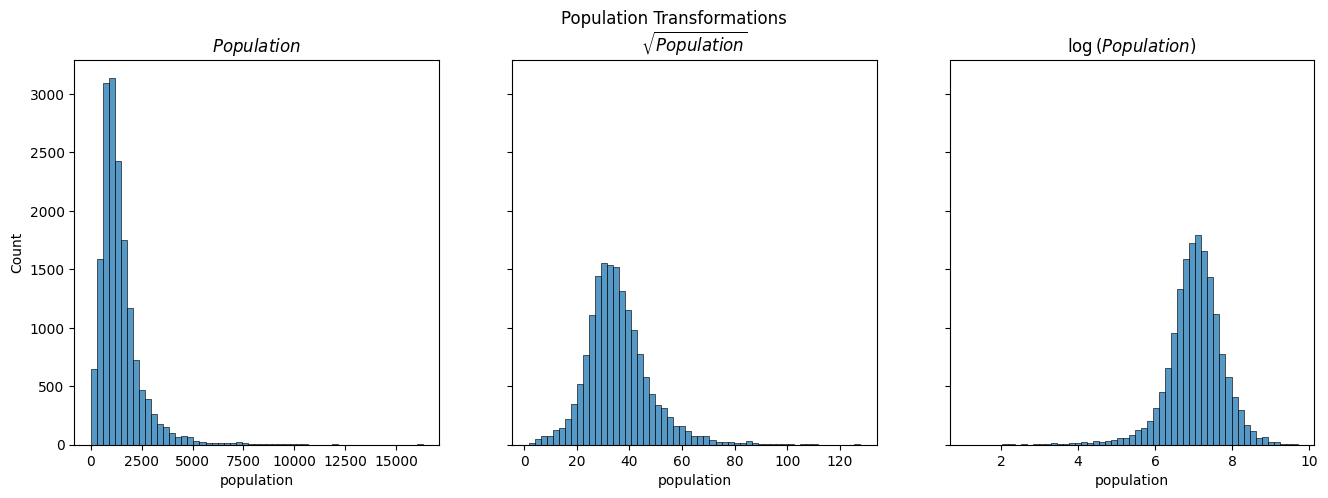

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
fig.suptitle('Population Transformations')

sns.histplot(ax=axes[0], x=housing_num['population'], bins=55);
axes[0].set_title('$Population$')


sns.histplot(ax=axes[1], x=np.sqrt(housing_num['population']), bins=55)
axes[1].set_title('$\sqrt{Population}$')

sns.histplot(ax=axes[2], x=np.log(housing_num['population']), bins=55)
axes[2].set_title('$\log{(Population)}$');

#### What about features with a multimodal distribution?

- Could bucketize the feature, but this time treating the bucket IDs as categories rather than numerical values
    - then use one hot encoding
- Could also add a feature for each of the modes (at least the main ones), representing the similarity between the feature (`housing_median_age`) and a particular mode
    - the similarity feature is typically computed using a ***radial basis function*** or **RBF**
        - which is any function that depends only on the distance between the input value and a fixed point
        - the most commmonly used RBF is the **Gaussian RBF**, whose output value decays exponentially as the input value moves away from the fixed point
            - can be implemented with Scikit-Learn's `rbf_kernel()` function

In [102]:
def my_rbf(X, mode_value, gamma):
    return np.exp(-gamma * (X - mode_value)**2)

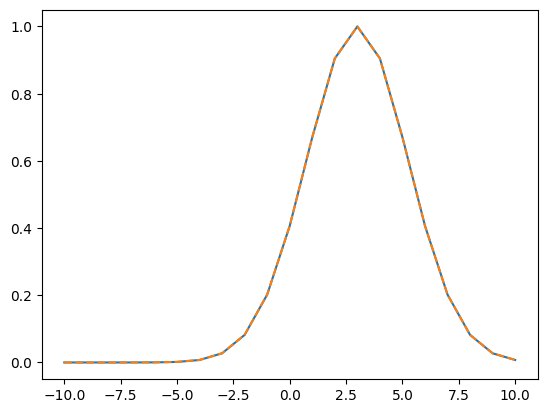

In [103]:
X = np.arange(-10, 11).reshape(-1, 1)
plt.plot(X, my_rbf(X, 3, 0.1))
plt.plot(X, rbf_kernel(X, [[3]], 0.1), linestyle='--');

In [104]:
age_simil_35_gamma0_1 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)
age_simil_35_gamma0_3 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.03)

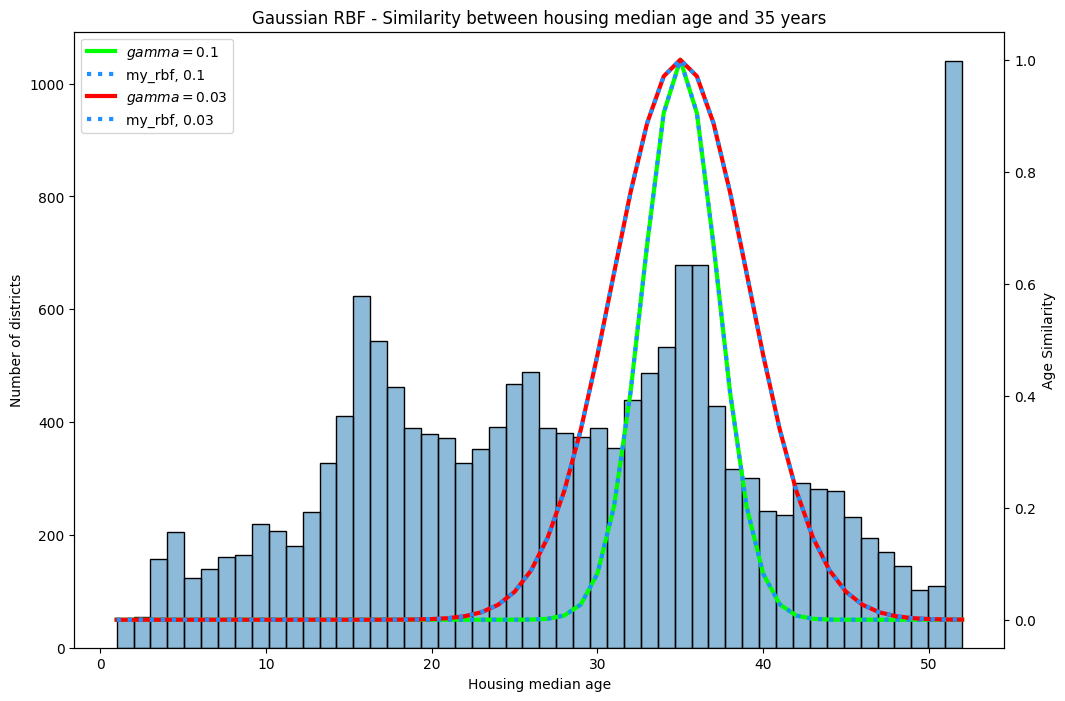

In [105]:
fig, ax = plt.subplots(figsize=(12, 8))
ax2 = ax.twinx()

sns.histplot(housing[['housing_median_age']],
             bins=50,
             ax=ax)

sns.lineplot(x=housing['housing_median_age'],
             y=age_simil_35_gamma0_1.flatten(),
             color='lime', linewidth=3, label='$gamma = 0.1$',
             ax=ax2)

sns.lineplot(x=housing['housing_median_age'],
             y=my_rbf(housing['housing_median_age'].values, 35, 0.1),
             color='dodgerblue', linewidth=3, linestyle='dotted', label='my_rbf, 0.1',
             ax=ax2)

sns.lineplot(x=housing['housing_median_age'],
             y=age_simil_35_gamma0_3.flatten(),
             color='red', linewidth=3, label='$gamma = 0.03$',
             ax=ax2)

sns.lineplot(x=housing['housing_median_age'],
             y=my_rbf(housing['housing_median_age'].values, 35, 0.03),
             color='dodgerblue', linewidth=3, linestyle='dotted', label='my_rbf, 0.03',
             ax=ax2)


ax.set_title('Gaussian RBF - Similarity between housing median age and 35 years')
ax.set_xlabel('Housing median age')
ax.legend_.remove()

ax.set_ylabel('Number of districts')
ax2.set_ylabel('Age Similarity')
ax2.legend(loc='upper left');

#### Transformation of the Target

- If the target distribution has a heavy tail, you may choose to replace the target with it's logarithm
- But that means the regression model will now predict the `log` of the `median_house_value` itself
    - No problem, Scikit-learn's transformers have an `inverse_transform()` method

In [106]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
scaled_labels

array([[ 2.18511202],
       [ 2.40625396],
       [-0.90740625],
       ...,
       [-0.49894408],
       [ 2.54675281],
       [ 0.23385961]])

In [107]:
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

LinearRegression()

In [108]:
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data
some_new_data

median_income
13096         2.0987
14973         6.0876
3785          2.4330
14689         2.2618
20507         3.5292

In [109]:
scaled_predictions = model.predict(some_new_data)
scaled_predictions

array([[-0.64466228],
       [ 0.80674175],
       [-0.52302364],
       [-0.5853166 ],
       [-0.12415952]])

In [110]:
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

#### `TransformedTargetRegressor()`

- The above works fine, but there is a simpler method

In [111]:
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())

model

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [112]:
model.fit(housing[['median_income']], housing_labels)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [113]:
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### Custom Transformers

#### Tranformations that don't require any training

- Just write a function that takes a numpy array as imput and outputs the tranformed array
    - For example, a log transformer (for positive right-tailed features)
- The `inverse_func` parameter is optional, but you need to include it, for example, if you want to use your transformer in a `TransformedTargetRegressor()`

In [114]:
log_transformer = FunctionTransformer(func=np.log,
                                      inverse_func=np.exp)
log_transformer

FunctionTransformer(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>)

In [115]:
log_pop = log_transformer.transform(housing[['population']])
log_pop

population
13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
...           ...
14207    6.843750
13105    7.257708
19301    7.942362
19121    7.452982
19888    6.525030

[16512 rows x 1 columns]

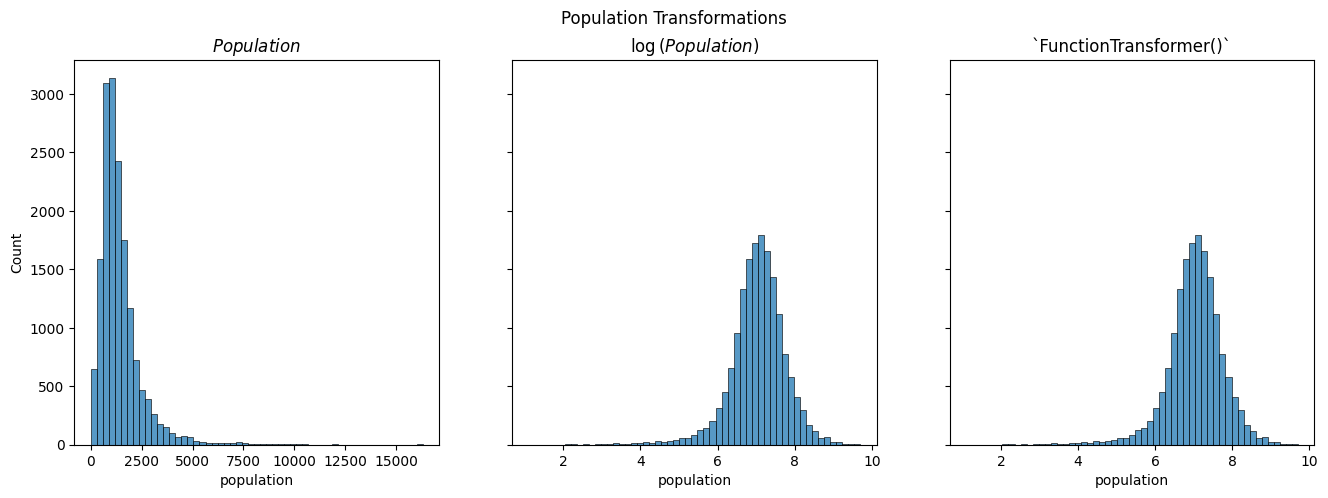

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
fig.suptitle('Population Transformations')

sns.histplot(ax=axes[0], x=housing_num['population'], bins=55);
axes[0].set_title('$Population$')

sns.histplot(ax=axes[1], x=np.log(housing_num['population']), bins=55)
axes[1].set_title('$\log{(Population)}$')

sns.histplot(ax=axes[2], x=log_pop['population'], bins=55)
axes[2].set_title('`FunctionTransformer()`');

In [117]:
(log_transformer.inverse_func(log_pop) - housing[['population']]).sum()

population    3.476774e-12
dtype: float64

##### Your transformation function can take hyperparameters as additional arguments

- recall: `age_simil_35_gamma0_1 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)`

In [118]:
rbf_transformer = FunctionTransformer(func=rbf_kernel, kw_args={'Y':[[35]],
                                                               'gamma': 0.1})

In [119]:
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

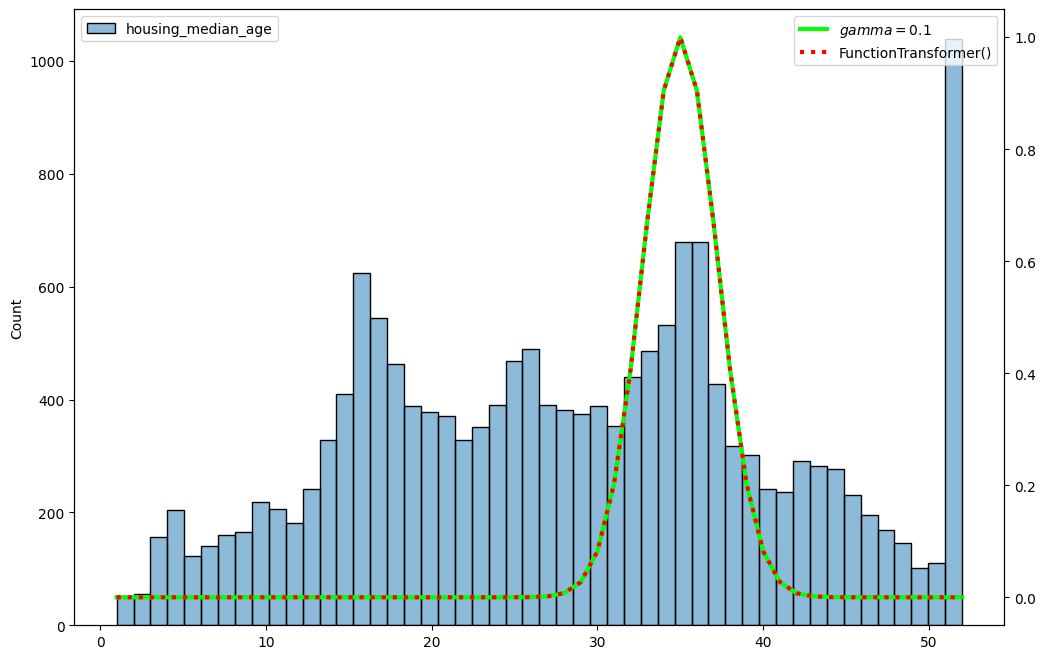

In [120]:
fig, ax = plt.subplots(figsize=(12, 8))
ax2 = ax.twinx()

sns.histplot(housing[['housing_median_age']],
             bins=50,
             ax=ax)

sns.lineplot(x=housing['housing_median_age'],
             y=age_simil_35_gamma0_1.flatten(),
             color='lime', linewidth=3, label='$gamma = 0.1$',
             ax=ax2)

sns.lineplot(x=housing['housing_median_age'],
             y=age_simil_35.flatten(),
             color='red', linewidth=3, linestyle='dotted', label='FunctionTransformer()',
             ax=ax2);

- Note that there is no inverse function for the RBF kernel
    - would not make sense since there are always two values at a given distance from a fixed point, except at distance 0
    - if you pass it an array with two feature, it will masure the 2D distance (Euclidian) to measure similarity

In [121]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords],
                                                              gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [122]:
sf_simil.shape

(16512, 1)

In [123]:
housing[['latitude', 'longitude']].shape

(16512, 2)

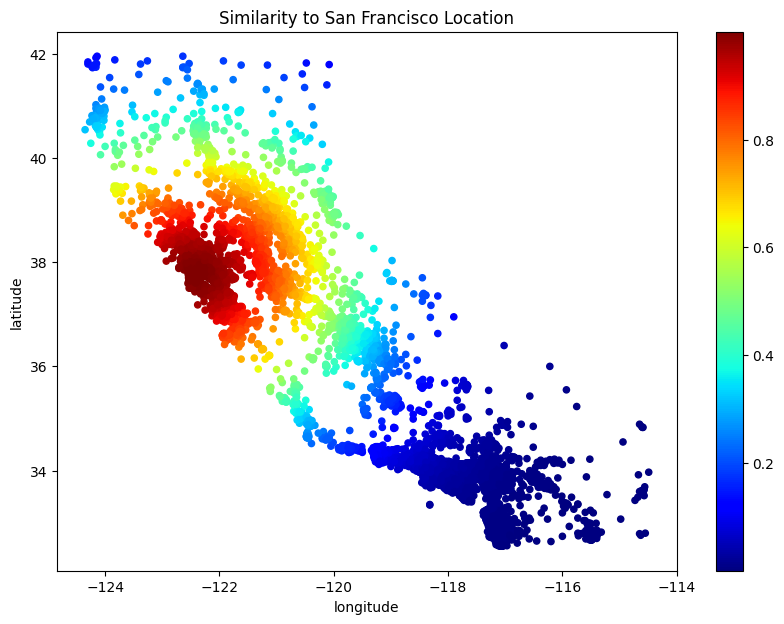

In [124]:
ax = housing.plot(kind='scatter',
                  x='longitude',
                  y='latitude',
                  c=sf_simil,
                  colorbar=True,
                  cmap='jet',
                  figsize=(10, 7),
                  title='Similarity to San Francisco Location');

In [125]:
from itertools import product

x = np.linspace(-25, 25, 300)
y = np.linspace(-25, 25, 300)

the_plane = pd.DataFrame(product(set(x), set(y)),
                         columns=['x', 'y'])

plane_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[0, 0], [10, 10]],
                                                                 gamma=0.003))
origin_simil = plane_transformer.transform(the_plane)

In [126]:
origin_simil

array([[0.99493741, 0.48897528],
       [0.99577243, 0.4943206 ],
       [0.99644095, 0.49964052],
       ...,
       [0.42704266, 0.05638114],
       [0.45439359, 0.06307862],
       [0.48683377, 0.07177538]])

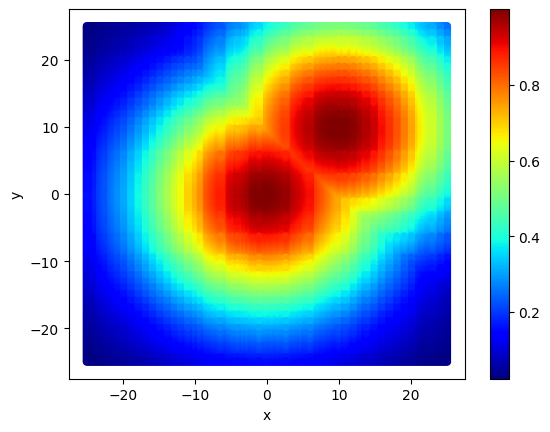

In [127]:
ax = the_plane.plot(kind='scatter',
                    x='x',
                    y='y',
                    c=origin_simil.max(axis=1),
                    cmap='jet')

##### Custom Transformer to combine features

In [128]:
X = np.array([[1, 2], [3, 4]])

In [129]:
X

array([[1, 2],
       [3, 4]])

In [130]:
X[:, [0]]

array([[1],
       [3]])

In [131]:
X[:, [1]]

array([[2],
       [4]])

In [132]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(X)

array([[0.5 ],
       [0.75]])

In [133]:
housing[['total_rooms', 'households']].values

array([[3321., 1034.],
       [1965.,  357.],
       [1083.,  203.],
       ...,
       [3920.,  760.],
       [3781.,  838.],
       [ 431.,  212.]])

In [134]:
ratio_transformer.transform(housing[['total_rooms', 'households']].values)

array([[3.21179884],
       [5.50420168],
       [5.33497537],
       ...,
       [5.15789474],
       [4.51193317],
       [2.03301887]])

In [135]:
housing['total_rooms'] / housing['households']

13096    3.211799
14973    5.504202
3785     5.334975
14689    5.351282
20507    3.725256
           ...   
14207    4.277247
13105    5.535714
19301    5.157895
19121    4.511933
19888    2.033019
Length: 16512, dtype: float64

In [136]:
# with feature_names_out


ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]],
                                        feature_names_out=lambda function_transformer, feature_names_in : ['ratio'])
ratio_transformer.transform(housing[['total_rooms', 'households']].values)

array([[3.21179884],
       [5.50420168],
       [5.33497537],
       ...,
       [5.15789474],
       [4.51193317],
       [2.03301887]])

In [137]:
ratio_transformer.get_feature_names_out()

array(['ratio'], dtype=object)

#### Trainable Tranformers

- 3 methods needed
    -  a `fit()` method to do the training
        - this method must return `self`
    - a `transform()` method
    - a `fit_transform()` method
        - you get this one for free by simply adding `TransformerMixin` as a base class
- If you had `BaseEstimator` as a base class (and avoid using \*args and \*\*kwargs in your constructor), you will also get two extra methods which are useful for hyperparameter tuning:
    - `get_params()`
    - `set_params()`

In [138]:
# acts much like the `StandardScaler()`

# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args or **kwargs
        self.with_mean = True

    def fit(self, X, y=None): # y is required even if we don't use it
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in `fit()`
        return self # always return self

    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [139]:
test = StandardScalerClone()
test.fit_transform(housing_num.drop('total_bedrooms', axis=1))

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

In [140]:
StandardScaler().fit_transform(housing_num.drop('total_bedrooms', axis=1))

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

- The implementation is not 100% complete
    - all estimators should set `feature_names_in_` in the `fit()` method when they are passed a DataFrame
    - all transformers should provide a `get_feature_names_out()` method
    - all transformers should provide an `inverse_transform()` method when their tranformations can be reversed
- A custom transformer can (and often does) use other estimators in its implementation
    - the next example uses a `KMeans` clusterer in the `fit()` method to identify the main clusters in the training data, and then uses `rbf_kernel` in the `transform()` method to measure how similar each sample is to each cluster centre

##### KMeans

In [141]:
# from sklearn.cluster import KMeans

test = housing[['longitude', 'latitude']]
kmeans = KMeans(10, random_state=42, n_init=10)
kmeans.fit(test)

KMeans(n_clusters=10, n_init=10, random_state=42)

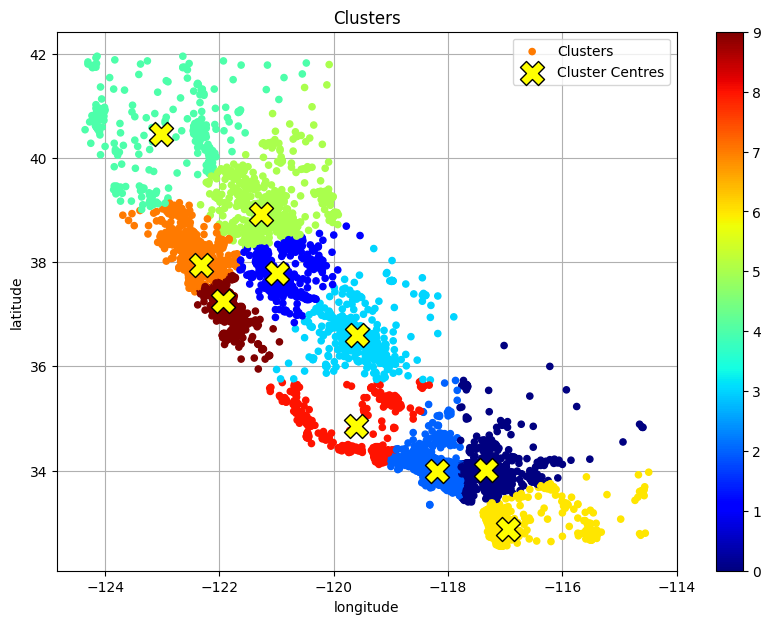

In [142]:
fig, ax = plt.subplots(figsize=(10, 7))
housing.plot(kind='scatter',
             x='longitude',
             y='latitude',
             c=kmeans.labels_,
             cmap='jet',
             title='Clusters',
             label='Clusters',
             grid=True,
             ax=ax)
ax.scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 1],
           marker='X',
           s=300,
           c='yellow',
           edgecolor='black',
           label='Cluster Centres')
ax.legend()
ax.set_axisbelow(True);

##### Trainable Custom Transformer with `KMeans` and `rbf_kernel`

In [143]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None, n_init=10):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        self.n_init = n_init

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,
                              random_state=self.random_state,
                              n_init=self.n_init)
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [144]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']],
                                           sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

In [145]:
similarities.max(axis=1).shape

(16512,)

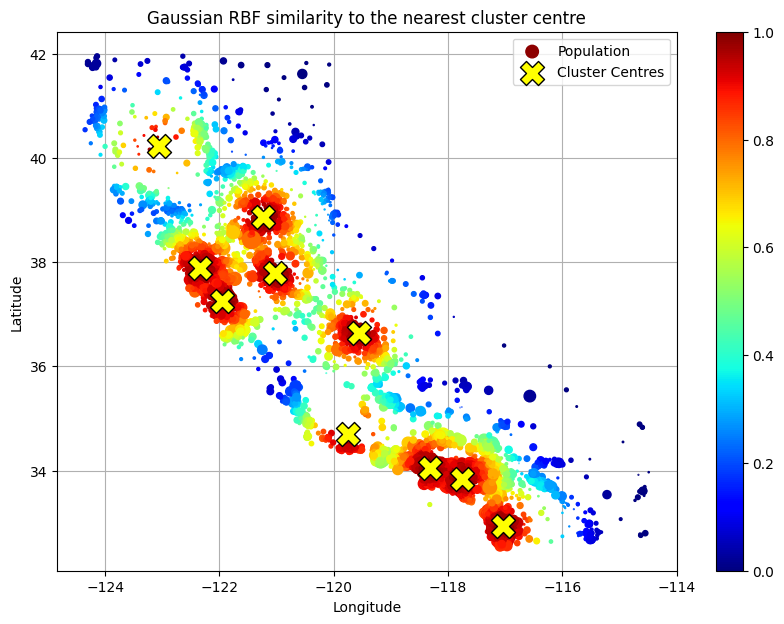

In [146]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x=housing['longitude'],
           y=housing['latitude'],
           s=housing['population'] / 100,
           c=similarities.max(axis=1),
           cmap='jet',
           label='Population')
ax.scatter(cluster_simil.kmeans_.cluster_centers_[:, 1],
           cluster_simil.kmeans_.cluster_centers_[:, 0],
           marker='X',
           s=300,
           c='yellow',
           edgecolor='black',
           label='Cluster Centres')

fig.colorbar(None, cmap='jet', ax=ax)
ax.set_title('Gaussian RBF similarity to the nearest cluster centre')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid()
ax.set_axisbelow(True);

##### TIP

You can check whether your custom estimator respects Scikit-Learn’s API by passing an instance to `check_estimator()` from the `sklearn.utils.estimator_checks` package. For the full API, check out https://scikit-learn.org/stable/developers.

### Transformation *Pipelines*

#### The `Pipeline` Constructor

- takes a list of name/estimator pairs (2-tuples) that define a sequence of steps
- rules for the name:
    - must be unique
    - must not contain double underscores __
- rules for the estimator:
    - except for the last one, they must all be transformers (`fit_transform()` method)
    - the last one can be anyting:
        - a transformer
        - a predictor
        - or any other type of estimator

In [147]:
# fron sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

- Alternately, you can use the `make_pipeline()` function instead
    - it takes transformers as positional arguments and creates a `Pipeline` using the names of the transformer's classes (in lowercase without underscores)
    - if multiple transformers have the same name, an index `-i` is appended to their names




In [148]:
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                            StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

- When you call the pipeline's `fit()` method, it calls `fit_transform()` sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which is just calls the `fit()` method
- The pipeline exposes the same methods as the final estimator
    - In our example, the final estimator is a transformer. If you call the pipelines `transform()` method it will sequentially apply all the transformations to the data
    - If the last estimator were a predictor instead of a transformer, calling `predict()` would sequentially apply all the transformations to the data and pass the result to the predictor's `predict()` method

In [149]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

In [150]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

df_housing_num_prepared

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   
...          ...       ...                 ...          ...             ...   
14207   0.586397 -0.833359            0.987087    -0.184147        0.140152   
13105   0.131525  0.319822           -0.443146     0.139847        0.128298   
19301   1.256209 -1.428701           -1.237721     0.586026        0.562134   
19121   0.586397 -0.739605            0.669257     0.522417        0.794461   
19888  -1.418038  0.947978            1.225459    -1.010608       -0.812864   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365  
...           ...         ...            ...  
14207   -0.445315    0.060101       0.444041  
13105   -0.005950    0.083608      -0.685630  
19301    1.268299    0.679135       0.101049  
19121    0.273563    0.882868       0.145396  
19888   -0.679156   -0.752219      -0.310341  

[16512 rows x 8 columns]

#### Pipeline Indexing

In [151]:
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [152]:
num_pipeline[0]

SimpleImputer(strategy='median')

In [153]:
num_pipeline[-1]

StandardScaler()

In [154]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [155]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [156]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler()}

In [157]:
num_pipeline.steps[0]

('simpleimputer', SimpleImputer(strategy='median'))

In [158]:
num_pipeline['simpleimputer']

SimpleImputer(strategy='median')

#### `ColumnTransformer()`

- Used to apply different pipelines to different columns

In [159]:
# from sklearn.compose import ColumnTransformer

In [160]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
               'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])


- takes a list of name/transformer/columns triples (3-tuples)
- rules for the name:
    - must be unique
    - must not contain double underscores __
- the transformer:
    - 'drop' and 'passthrough' are also accepted
- columns: the string names of the columns that the transformer should be applied to

In [161]:
preprocessing.fit_transform(housing)

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [162]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

In [163]:
preprocessing = ColumnTransformer([
    ('num', 'passthrough', num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [164]:
preprocessing.fit_transform(housing)

array([[-122.42,   37.8 ,   52.  , ...,    0.  ,    1.  ,    0.  ],
       [-118.38,   34.14,   40.  , ...,    0.  ,    0.  ,    0.  ],
       [-121.98,   38.36,   33.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [-117.06,   32.59,   13.  , ...,    0.  ,    0.  ,    1.  ],
       [-118.4 ,   34.06,   37.  , ...,    0.  ,    0.  ,    0.  ],
       [-122.41,   37.66,   44.  , ...,    0.  ,    0.  ,    1.  ]])

In [165]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

In [166]:
preprocessing = ColumnTransformer([
    ('num', 'drop', num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [167]:
preprocessing.fit_transform(housing).toarray() # it was sparse

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

- Alternately, the `make_column_selector()` and `make_column_transformer()` functions can be used

In [168]:
# from sklearn.compose import make_column_selector, make_column_transformer

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
#               'total_bedrooms', 'population', 'households', 'median_income']
# cat_attribs = ['ocean_proximity']

# preprocessing = ColumnTransformer([
#     ('num', num_pipeline, num_attribs),
#     ('cat', cat_pipeline, cat_attribs)
# ])

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    ('passthrough', make_column_selector(dtype_include=object))
)

In [169]:
preprocessing.fit_transform(housing)

array([[-1.4230365222084413, 1.0136058988887096, 1.8611187475164104, ...,
        1.394812491429575, -0.9364914916124666, 'NEAR BAY'],
       [0.5963944502515679, -0.7021029984815921, 0.9076297101651685, ...,
        -0.3734847142852014, 1.171941975054816, '<1H OCEAN'],
       [-1.2030984955048774, 1.2761187356448225, 0.35142777171027734,
        ..., -0.7757266192779274, -0.7597888147073368, 'INLAND'],
       ...,
       [1.2562085303622597, -1.4287010287886863, -1.237720623875126, ...,
        0.6791353357931661, 0.10104869533661943, 'NEAR OCEAN'],
       [0.5863972672195826, -0.7396048323038931, 0.669257450827358, ...,
        0.8828682487115599, 0.14539615149079343, '<1H OCEAN'],
       [-1.4180379306924487, 0.9479776896996812, 1.2254593892822492, ...,
        -0.7522189754796512, -0.31034135382659506, 'NEAR OCEAN']],
      dtype=object)

In [170]:
preprocessing.get_feature_names_out()

array(['pipeline__longitude', 'pipeline__latitude',
       'pipeline__housing_median_age', 'pipeline__total_rooms',
       'pipeline__total_bedrooms', 'pipeline__population',
       'pipeline__households', 'pipeline__median_income',
       'passthrough__ocean_proximity'], dtype=object)

In [171]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

housing_num_prepared = preprocessing.fit_transform(housing)
housing_num_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [172]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

#### Putting it all together in a single pipeline

##### Recap what the pipeline will do

- impute missing values (with 'median' or 'most_frequent'
- one-hot encode categorical features
- compute some ratio features:
    - `bedrooms_ratio`
    - `rooms_per_house`
    - `people_per_house`
- add a few cluster similarity features
    - likely more useful than `latitude` and `longitude`
- features with a long tail will be replaced by their logarithm
- all numerical features will be standardized

In [173]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population',
                           'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline) # one column remaining: housing_median_age

In [174]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[ 1.84662439, -0.86602737, -0.33020372, ...,  1.        ,
         0.        ,  1.86111875],
       [-0.5081207 ,  0.0245495 , -0.25361631, ...,  0.        ,
         0.        ,  0.90762971],
       [-0.20215476, -0.04119332, -0.05104091, ...,  0.        ,
         0.        ,  0.35142777],
       ...,
       [-0.24249175, -0.10998748,  0.15854151, ...,  0.        ,
         1.        , -1.23772062],
       [ 0.25977479, -0.36093745, -0.21033248, ...,  0.        ,
         0.        ,  0.66925745],
       [ 3.61270996, -1.32397227,  0.04958379, ...,  0.        ,
         1.        ,  1.22545939]])

In [175]:
housing_prepared.shape

(16512, 24)

In [176]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [177]:
test = pd.DataFrame(housing_prepared,
                    columns=preprocessing.get_feature_names_out(),
                    index=housing.index)

test.head()

bedrooms__ratio  rooms_per_house__ratio  people_per_house__ratio  \
13096         1.846624               -0.866027                -0.330204   
14973        -0.508121                0.024550                -0.253616   
3785         -0.202155               -0.041193                -0.051041   
14689        -0.149006               -0.034858                -0.141475   
20507         0.963208               -0.666554                -0.306148   

       log__total_bedrooms  log__total_rooms  log__population  \
13096             1.324114          0.637892         0.456906   
14973            -0.252671         -0.063576        -0.711654   
3785             -0.925266         -0.859927        -0.941997   
14689             0.952773          0.943475         0.670700   
20507             1.437622          1.003590         0.719093   

       log__households  log__median_income  geo__Cluster 0 similarity  \
13096         1.310369           -1.071522               3.788947e-18   
14973        -0.142030            1.194712               3.346712e-01   
3785         -0.913030           -0.756981               2.874903e-18   
14689         0.925373           -0.912253               8.832834e-01   
20507         1.481464            0.034537               4.893551e-01   

       geo__Cluster 1 similarity  ...  geo__Cluster 6 similarity  \
13096               1.319640e-01  ...               3.398866e-24   
14973               1.735776e-09  ...               2.706351e-02   
3785                2.749482e-01  ...               1.020912e-24   
14689               2.237307e-14  ...               4.613653e-01   
20507               2.891966e-11  ...               1.092264e-01   

       geo__Cluster 7 similarity  geo__Cluster 8 similarity  \
13096               9.698809e-01               7.073518e-08   
14973               8.786936e-14               1.275435e-01   
3785                7.483836e-01               1.871204e-08   
14689               3.428945e-20               5.336846e-04   
20507               7.073121e-16               3.490774e-02   

       geo__Cluster 9 similarity  cat__ocean_proximity_<1H OCEAN  \
13096               5.824761e-01                             0.0   
14973               2.078829e-10                             1.0   
3785                2.896858e-01                             0.0   
14689               3.778950e-16                             0.0   
20507               3.361020e-12                             0.0   

       cat__ocean_proximity_INLAND  cat__ocean_proximity_ISLAND  \
13096                          0.0                          0.0   
14973                          0.0                          0.0   
3785                           1.0                          0.0   
14689                          1.0                          0.0   
20507                          0.0                          0.0   

       cat__ocean_proximity_NEAR BAY  cat__ocean_proximity_NEAR OCEAN  \
13096                            1.0                              0.0   
14973                            0.0                              0.0   
3785                             0.0                              0.0   
14689                            0.0                              0.0   
20507                            0.0                              1.0   

       remainder__housing_median_age  
13096                       1.861119  
14973                       0.907630  
3785                        0.351428  
14689                      -0.919891  
20507                       0.589800  

[5 rows x 24 columns]

In [178]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bedrooms__ratio                  16512 non-null  float64
 1   rooms_per_house__ratio           16512 non-null  float64
 2   people_per_house__ratio          16512 non-null  float64
 3   log__total_bedrooms              16512 non-null  float64
 4   log__total_rooms                 16512 non-null  float64
 5   log__population                  16512 non-null  float64
 6   log__households                  16512 non-null  float64
 7   log__median_income               16512 non-null  float64
 8   geo__Cluster 0 similarity        16512 non-null  float64
 9   geo__Cluster 1 similarity        16512 non-null  float64
 10  geo__Cluster 2 similarity        16512 non-null  float64
 11  geo__Cluster 3 similarity        16512 non-null  float64
 12  geo__Cluster 4

## Select and Train a Model

### Train and Evaluate on the Training Set

In [179]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('linearregression', LinearRegression())])

In [180]:
housing_predictions = lin_reg.predict(housing)

In [181]:
housing_predictions

array([243713.20602735, 372357.32638638, 128778.47225482, ...,
       189494.38806937, 307031.9357244 , 252569.33026591])

In [182]:
# the first 5 predictions don't look great, the first one is way off
print(housing_predictions[:5].round(-2)) # round to nearest hundred
print(housing_labels[:5].values)

[243700. 372400. 128800.  94400. 328300.]
[458300. 483800. 101700.  96100. 361800.]


#### Root Mean Squared Error

In [183]:
# from sklearn.metrics import mean_squared_error

mse = mean_squared_error(housing_labels, housing_predictions, squared=True)
rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

mse, rmse

(4718026475.244044, 68687.89176590038)

In [184]:
# from first principles

m = len(housing_predictions)
my_mse = (1 / m) *  sum((housing_predictions - housing_labels.values) **2)
my_rmse = np.sqrt(my_mse)

my_mse, my_rmse

(4718026475.244009, 68687.89176590012)

In [185]:
rmse # the measure we wanted

68687.89176590038

In [186]:
housing_labels.median()

179200.0

- A typical prediction error of 68K is not great considering a median housing price of 179K.
- This is typical **underfitting** maybe because:
    - The features do not provide enough information to make a good prediction
    - The model is not powerful enough

#### 3 possible solutions to the underfitting

1. Select a more powerful model
2. Feed the algorithm with better features
3. Reduce the constraints on the model

- The third option does not apply here since the model is not regularized.
- We will try another model

##### `LinearRegression()`

In [187]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('linearregression', LinearRegression())])

In [188]:
lin_predictions = lin_reg.predict(housing)
lin_rmse = mean_squared_error(housing_labels, lin_predictions, squared=False)
lin_rmse

68687.89176590038

##### `DecisionTreeRegressor()`

In [189]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [190]:
tree_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, tree_predictions, squared=False)
tree_rmse

0.0

- An RMSE of 0? No error at all? More likely underfitting
- How can we be sure? We need a test set for that.

### Better Evaluation Using Cross-Validation

- Before doing that, let's try using `train_test_split()` to split the training set into a smaller training set and a validation set

In [191]:
X_train, X_val, y_train, y_val = train_test_split(
    housing,
    housing_labels,
    test_size=0.33,
    random_state=42
)

In [192]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11063, 9), (5449, 9), (11063,), (5449,))

In [193]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [194]:
# predictions on the validation set
tree_predictions = tree_reg.predict(X_train)
tree_rmse = mean_squared_error(y_train, tree_predictions, squared=False)
tree_rmse

0.0

In [195]:
# predictions on the validation set
tree_predictions = tree_reg.predict(X_val)
tree_rmse = mean_squared_error(y_val, tree_predictions, squared=False)
tree_rmse # overfitting, as expected

69044.6704012564

- Now using Cross Validation with `cross_val_score`
    - the following code randomly splits the training set into 10 nonoverlapping subets called **folds**: `cv=10`
    - then it trains and evaluates the model 10 times, picking a different fold for evaluation each time and using the remaining 9 folds for training
    - note that the `scoring` parameter expects a **utility function** rather than a **cost function**. To convert, simply take the negative
    - possible values for the `scoring` parameter: https://scikit-learn.org/stable/modules/model_evaluation.html

In [196]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [197]:
# from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg,
                              housing,
                              housing_labels,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

tree_rmses

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [198]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

- We see now that the decision tree doesn't perform much better than linear regression
- Note that cross-validation allows you to get no only an estimate of the performance of your model, but also a measure of how precise the estimate is (standard deviation)
- Our tree model has an RMSE of 66868 and a standard deviation of about 2061.

##### `RandomForestRegressor()`

In [199]:
# from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [200]:
forest_rmses = -cross_val_score(forest_reg,
                                housing,
                                housing_labels,
                                scoring='neg_root_mean_squared_error',
                                cv=10)

forest_rmses

array([46336.33927043, 47340.03146064, 45458.11252725, 46847.10692372,
       46004.08554711, 46955.59525055, 46979.59745817, 49243.76579537,
       47748.29301325, 47282.68556492])

In [201]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

- Random Forest appears to be very promising for this task
- It is better than linear regression and better than Decision Tree
- But it is still overfitting (notice the RMSE if we use the whole training set as shown below)

In [202]:
forest_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f0...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [203]:
forest_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, forest_predictions, squared=False)
forest_rmse

17474.619286483998

- At this stage, try as many learning algorithms as possible without worrying too much about tweaking hyperparameters
    - the goal is to get a short list of promising algorithms (2 to 5)

## Fine-Tune Your Model

- Let's assume we have a shortlist of promising models to be used for fine-tuning

### Grid Search

In [204]:
# from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])

full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f07643...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                ('random_forest', RandomForestRegressor(random_state=42))])

- You can refer to any hyperparameter of any estimator in a pipeline, even if the estimator is nested deep inside several pipelines and column transformers
    - `"preprocessing__geo__n_clusters"`
        - the string is split at the double underscores
            1. `"preprocessing"`: the estimator name
            2. `"geo"`: the transformer name
            3. `"n_clusters"`: the hyperparameter
- TIP: wrapping preprocessing steps in a pipeline allows you to tune the preprocessing hyperparameters along with the model hyperparameters
    - sometimes they interact, for example, maybe increasing `n_clusters` requires increasing `max_features` as well
- **TIP**: experiment with the piplines `memory` parameter

In [205]:
param_grid = [
    # first it will evaluate 3 * 3 = 9 combinations
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},

    # then it will evaluate 2 * 3 = 6 combinations
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}

    # at total of 15 combinations will be evaluated
]

grid_search = GridSearchCV(estimator=full_pipeline,
                           param_grid=param_grid,
                           cv=3, # 15 * 3 = 45 rounds of training
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f076456a7a0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [206]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [207]:
grid_search.best_score_

-44042.004170883105

In [208]:
grid_search.best_estimator_ # GridSearchCV: `refit=True` is the default and necessary to get the best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f07643...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f075f57f6a0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [209]:
grid_search.best_index_

12

In [210]:
grid_search.cv_results_['params'][grid_search.best_index_]

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

#### `GridSearchCV(refit=True)`

- `refit=True` is the default
- needed to get `grid_search.best_estimator_`
    - once `GridSearchCV` finds the best estimator using cross-validation, it retrains (refits) it on the whole training set
    - which is good, since feeding it more data will usually improve performance

#### `.cv_results_`

- the evalution scores
- this is a dictionary: easier to read when wrapped in a DataFrame

In [211]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12       7.783737      0.427364         0.238129        0.029271   
13       8.966399      0.784735         0.206686        0.013248   
14      11.290682      1.073743         0.216085        0.013604   
7        7.362513      0.534352         0.201214        0.009339   
9        7.489448      0.675536         0.212791        0.006398   
6        5.416593      0.312334         0.227752        0.029251   
4        7.229756      0.667823         0.199498        0.009096   
8        8.915988      0.730258         0.202895        0.013987   
10       8.839150      0.407697         0.234179        0.013548   
3        5.365937      0.685633         0.226173        0.035173   
5        9.061812      0.388119         0.234005        0.028311   
11      10.496618      0.624378         0.203683        0.012342   
1        7.058202      0.656813         0.212352        0.009751   
0        5.361605      0.320344         0.212819        0.025476   
2        8.570527      0.728807         0.230942        0.036698   

   param_preprocessing__geo__n_clusters param_random_forest__max_features  \
12                                   15                                 6   
13                                   15                                 8   
14                                   15                                10   
7                                    10                                 6   
9                                    10                                 6   
6                                    10                                 4   
4                                     8                                 6   
8                                    10                                 8   
10                                   10                                 8   
3                                     8                                 4   
5                                     8                                 8   
11                                   10                                10   
1                                     5                                 6   
0                                     5                                 4   
2                                     5                                 8   

                                               params  split0_test_score  \
12  {'preprocessing__geo__n_clusters': 15, 'random...      -43459.598047   
13  {'preprocessing__geo__n_clusters': 15, 'random...      -44132.027207   
14  {'preprocessing__geo__n_clusters': 15, 'random...      -44374.325167   
7   {'preprocessing__geo__n_clusters': 10, 'random...      -44683.355320   
9   {'preprocessing__geo__n_clusters': 10, 'random...      -44683.355320   
6   {'preprocessing__geo__n_clusters': 10, 'random...      -44556.999144   
4   {'preprocessing__geo__n_clusters': 8, 'random_...      -45200.755429   
8   {'preprocessing__geo__n_clusters': 10, 'random...      -45191.511586   
10  {'preprocessing__geo__n_clusters': 10, 'random...      -45191.511586   
3   {'preprocessing__geo__n_clusters': 8, 'random_...      -45280.997538   
5   {'preprocessing__geo__n_clusters': 8, 'random_...      -45508.824559   
11  {'preprocessing__geo__n_clusters': 10, 'random...      -45552.820141   
1   {'preprocessing__geo__n_clusters': 5, 'random_...      -47354.177804   
0   {'preprocessing__geo__n_clusters': 5, 'random_...      -47412.016772   
2   {'preprocessing__geo__n_clusters': 5, 'random_...      -47484.861669   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
12      -43918.632694      -44747.781772    -44042.004171      533.085183   
13      -44075.251239      -45009.672809    -44405.650418      427.736807   
14      -44285.549219      -45316.375999    -44658.750128      466.421934   
7       -44654.825561      -45657.384730    -44998.521871      466.031964   
9       -44654.825561      -45657.384730    -44998.521871      466.031964   
6  

### Randomized Search

- `RandomizedSearchCV` is often preferred over `GridSearchCV`, especially when the hyperparameter search space is large
- instead of trying every possible combination, it evaluates a fixed number of combinations, selecting a random value for each hyperparamter at every interation
    - very helpful is some of your hyperparameters are coninuous (or discrete with may possiblev values)
    - helpful if a hyperparameter does not make an difference (but you don't know that in advance)
    - you have not choice about how many combinations there will be with `GridSearchCV`, but you can choose this yourself with `RandomizedSearchCV` by setting `n_iter` (the default is 10)
- for each hyperparameter you must provide either a list of possible values or a probability distribution

In [212]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f075ede43a0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f075ede4430>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [213]:
grid_search.best_params_, rnd_search.best_params_

({'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6},
 {'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9})

In [214]:
grid_search.best_score_, rnd_search.best_score_

(-44042.004170883105, -41994.87608611436)

In [215]:
rnd_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f07643...
                                                  ClusterSimilarity(n_clusters=45,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f075ede4070>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=9, random_state=42))])

In [216]:
rnd_cv_res = pd.DataFrame(rnd_search.cv_results_)
rnd_cv_res.sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      11.045600      0.226554         0.214121        0.002210   
8       8.557795      0.509602         0.242820        0.037585   
0      16.964014      0.198613         0.236068        0.018999   
5       6.393742      0.995641         0.236103        0.016797   
2       9.975548      1.088905         0.210428        0.026232   
6       5.644165      0.993966         0.240942        0.026232   
7      14.523738      1.084650         0.275476        0.037527   
3      12.783248      0.206418         0.239893        0.026841   
4       6.412007      0.328421         0.208709        0.017921   
9       3.462887      0.389223         0.210822        0.005895   

  param_preprocessing__geo__n_clusters param_random_forest__max_features  \
1                                   45                                 9   
8                                   32                                 7   
0                                   41                                16   
5                                   42                                 4   
2                                   23                                 8   
6                                   24                                 3   
7                                   26                                13   
3                                   21                                12   
4                                   13                                 5   
9                                    4                                 2   

                                              params  split0_test_score  \
1  {'preprocessing__geo__n_clusters': 45, 'random...      -41286.610782   
8  {'preprocessing__geo__n_clusters': 32, 'random...      -41689.984035   
0  {'preprocessing__geo__n_clusters': 41, 'random...      -42223.254183   
5  {'preprocessing__geo__n_clusters': 42, 'random...      -41817.935999   
2  {'preprocessing__geo__n_clusters': 23, 'random...      -42263.593330   
6  {'preprocessing__geo__n_clusters': 24, 'random...      -42693.151437   
7  {'preprocessing__geo__n_clusters': 26, 'random...      -43097.207968   
3  {'preprocessing__geo__n_clusters': 21, 'random...      -43720.747459   
4  {'preprocessing__geo__n_clusters': 13, 'random...      -43901.682368   
9  {'preprocessing__geo__n_clusters': 4, 'random_...      -50364.338235   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
1      -42070.533721      -42627.483756    -41994.876086      550.017055   
8      -42512.726146      -43223.547238    -42475.419140      626.630079   
0      -42959.048891      -43320.889998    -42834.397690      456.694309   
5      -43094.489045      -43816.506749    -42909.643931      826.315940   
2      -42995.980237      -43830.097592    -43029.890386      639.972043   
6      -43420.953776      -44440.604297    -43518.236504      716.703482   
7      -43520.520499      -44175.460132    -43597.729533      443.567250   
3      -43914.530686      -44543.230157    -44059.502767      351.076559   
4      -43710.486286      -45086.600383    -44232.923012      608.666726   
9      -49739.778265      -51559.504125    -50554.540208      754.976001   

   rank_test_score  
1                1  
8                2  
0                3  
5                4  
2                5  
6                6  
7                7  
3                8  
4                9  
9               10

### Analyzing the Best Models and Their Errors

- One can gain good insights on the problem by inspecting the best models
- For example, `RandomForestRegressor` can indicate relative importance of each attribute

In [217]:
final_model = rnd_search.best_estimator_
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f07643...
                                                  ClusterSimilarity(n_clusters=45,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f075ede4070>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=9, random_state=42))])

In [218]:
final_model['random_forest']

RandomForestRegressor(max_features=9, random_state=42)

In [219]:
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [220]:
final_model['preprocessing'].get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'geo__Cluster 10 similarity',
       'geo__Cluster 11 similarity', 'geo__Cluster 12 similarity',
       'geo__Cluster 13 similarity', 'geo__Cluster 14 similarity',
       'geo__Cluster 15 similarity', 'geo__Cluster 16 similarity',
       'geo__Cluster 17 similarity', 'geo__Cluster 18 similarity',
       'geo__Cluster 19 similarity', 'geo__Cluster 20 similarity',
       'geo__Cluster 21 similarity', 'geo__Cluster 22 similarity',
       'geo__Cluster 23 similarity', 'ge

In [221]:
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
       reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

- It might be a good idea to drop some of the less useful features
- Only one of the `ocean_proximity` fatures is important, maybe drop the others
- TIP: investigate using `sklearn.feature_selection.SelectFromModel` transformer to automatically drop the least useful features
- TIP: investigate `HalvingRandomSearchCV` and `HalvingGridSearchCV`
- TIP: ensure your model not only works well on average, but works well for all categories of districts: rural vs. urban, rich or poor, northern vs southern, minority or not, etch
    - create subest of your validation set takes work, but it's important
    - if your model performs poorly on a category, then it probably should not be deployed until the issue is solved (or at least not used to make predictions for that category)

### Evaluate Your System on the Test Set

In [222]:
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f07643...
                                                  ClusterSimilarity(n_clusters=45,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f075ede4070>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=9, random_state=42))])

In [223]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

41424.40026462184

- Sometimes a point estimate is not enough to convince you to launch
    - What is your model is just 0.1% better than the model currently in production?
    - You may want to compure a **confidence interval** for the generalization error

In [224]:
# from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test)**2

In [225]:
np.sqrt(stats.t.interval(confidence,
                 len(squared_errors) - 1,
                 loc=squared_errors.mean(),
                 scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

## Launch, Monitor, and Maintain Your System

In [226]:
import joblib

joblib.dump(final_model, data_path + 'my_california_housing_model.pkl')

['/content/gdrive/MyDrive/Colab Notebooks/Data Science/Hands-On Machine Learning - Book/data/my_california_housing_model.pkl']

- It is often a good idea to save every model you experiment with
- You may also want to save cross-validation scores and the actual predictions on the validation set
- This will allow you to easily compare scores across models and compare the types of errors they make

In [227]:
# note, this must be tested in another notebook to make sure it has
#  all dependencies
#    - custom classes
#    - custom functions

# import joblib
# [...]  # import KMeans, BaseEstimator, TransformerMixin, rbf_kernel, etc.

# def column_ratio(X): [...]
# def ratio_name(function_transformer, feature_names_in): [...]
# class ClusterSimilarity(BaseEstimator, TransformerMixin): [...]

final_model_reloaded = joblib.load(data_path + "my_california_housing_model.pkl")

# new_data = [...]  # some new districts to make predictions for
new_data = X_test # pretend this is new data
predictions = final_model_reloaded.predict(new_data)

predictions

array([427257.32      , 211239.        , 381153.77071429, ...,
       209466.        , 200066.        , 190611.01      ])